In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt

import pickle

# Data Overview

In [2]:
df = pd.read_excel('Telco_customer_churn_adapted_v2.xlsx')

In [3]:
df.head().style.background_gradient()

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005000,Yes,106.816666,-6.200000,4210.700000
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910000,Yes,106.816666,-6.200000,3511.300000
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545000,Yes,106.816666,-6.200000,6983.600000
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240000,Yes,106.816666,-6.200000,6503.900000
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810000,Yes,106.816666,-6.200000,6942.000000


In [4]:
df.shape

(7043, 16)

In [5]:
list_item = []
for col in df.columns:
    list_item.append([col, df[col].dtype, df[col].isna().sum(), 100*df[col].isna().sum()/len(df[col]), df[col].nunique(), df[col].unique()[:4]])
desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
desc_df.style.background_gradient()

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,Customer ID,int64,0,0.000000,7043,[0 1 2 3]
1,Tenure Months,int64,0,0.000000,73,[ 2 8 28 49]
2,Location,object,0,0.000000,2,['Jakarta' 'Bandung']
3,Device Class,object,0,0.000000,3,['Mid End' 'High End' 'Low End']
4,Games Product,object,0,0.000000,3,['Yes' 'No' 'No internet service']
5,Music Product,object,0,0.000000,3,['Yes' 'No' 'No internet service']
6,Education Product,object,0,0.000000,3,['No' 'Yes' 'No internet service']
7,Call Center,object,0,0.000000,2,['No' 'Yes']
8,Video Product,object,0,0.000000,3,['No' 'Yes' 'No internet service']
9,Use MyApp,object,0,0.000000,3,['No' 'Yes' 'No internet service']


In [6]:
df.describe()

,Customer ID,Tenure Months,Monthly Purchase (Thou. IDR),Longitude,Latitude,CLTV (Predicted Thou. IDR)
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,3521.000000,32.371149,84.190200,107.043246,-6.404184,5720.384481
std,2033.283305,24.559481,39.117061,0.358316,0.322898,1537.974298
min,0.000000,0.000000,23.725000,106.816666,-6.914744,2603.900000
25%,1760.500000,9.000000,46.150000,106.816666,-6.914744,4509.700000
50%,3521.000000,29.000000,91.455000,106.816666,-6.200000,5885.100000
75%,5281.500000,55.000000,116.805000,107.609810,-6.200000,6994.650000
max,7042.000000,72.000000,154.375000,107.609810,-6.200000,8450.000000


In [7]:
df[df['Churn Label'] == 'No']['Monthly Purchase (Thou. IDR)'].mean()

79.6446608040201

In [8]:
df['Tenure Months'].value_counts()

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: Tenure Months, Length: 73, dtype: int64

The minority class (churned) covers 26% proportion of the dataset, this indicate the mildly imbalanced dataset.

In [9]:
df['Churn Label'].value_counts(normalize=True)*100

No     73.463013
Yes    26.536987
Name: Churn Label, dtype: float64

In [10]:
df['Churn Label'].value_counts()

No     5174
Yes    1869
Name: Churn Label, dtype: int64

# Data Cleaning

### Null

In [11]:
df.isnull().sum()

Customer ID                     0
Tenure Months                   0
Location                        0
Device Class                    0
Games Product                   0
Music Product                   0
Education Product               0
Call Center                     0
Video Product                   0
Use MyApp                       0
Payment Method                  0
Monthly Purchase (Thou. IDR)    0
Churn Label                     0
Longitude                       0
Latitude                        0
CLTV (Predicted Thou. IDR)      0
dtype: int64

### Duplicate

In [12]:
df.duplicated().sum()

0

### Outliers

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
numerical_cols = df.select_dtypes(exclude='object').columns
# exclude ID, Longitude, Latitude
numerical_cols = list(set(numerical_cols)-(set(['Customer ID', 'Longitude', 'Latitude'])))
numerical_cols

['Monthly Purchase (Thou. IDR)', 'Tenure Months', 'CLTV (Predicted Thou. IDR)']

### Double Axis

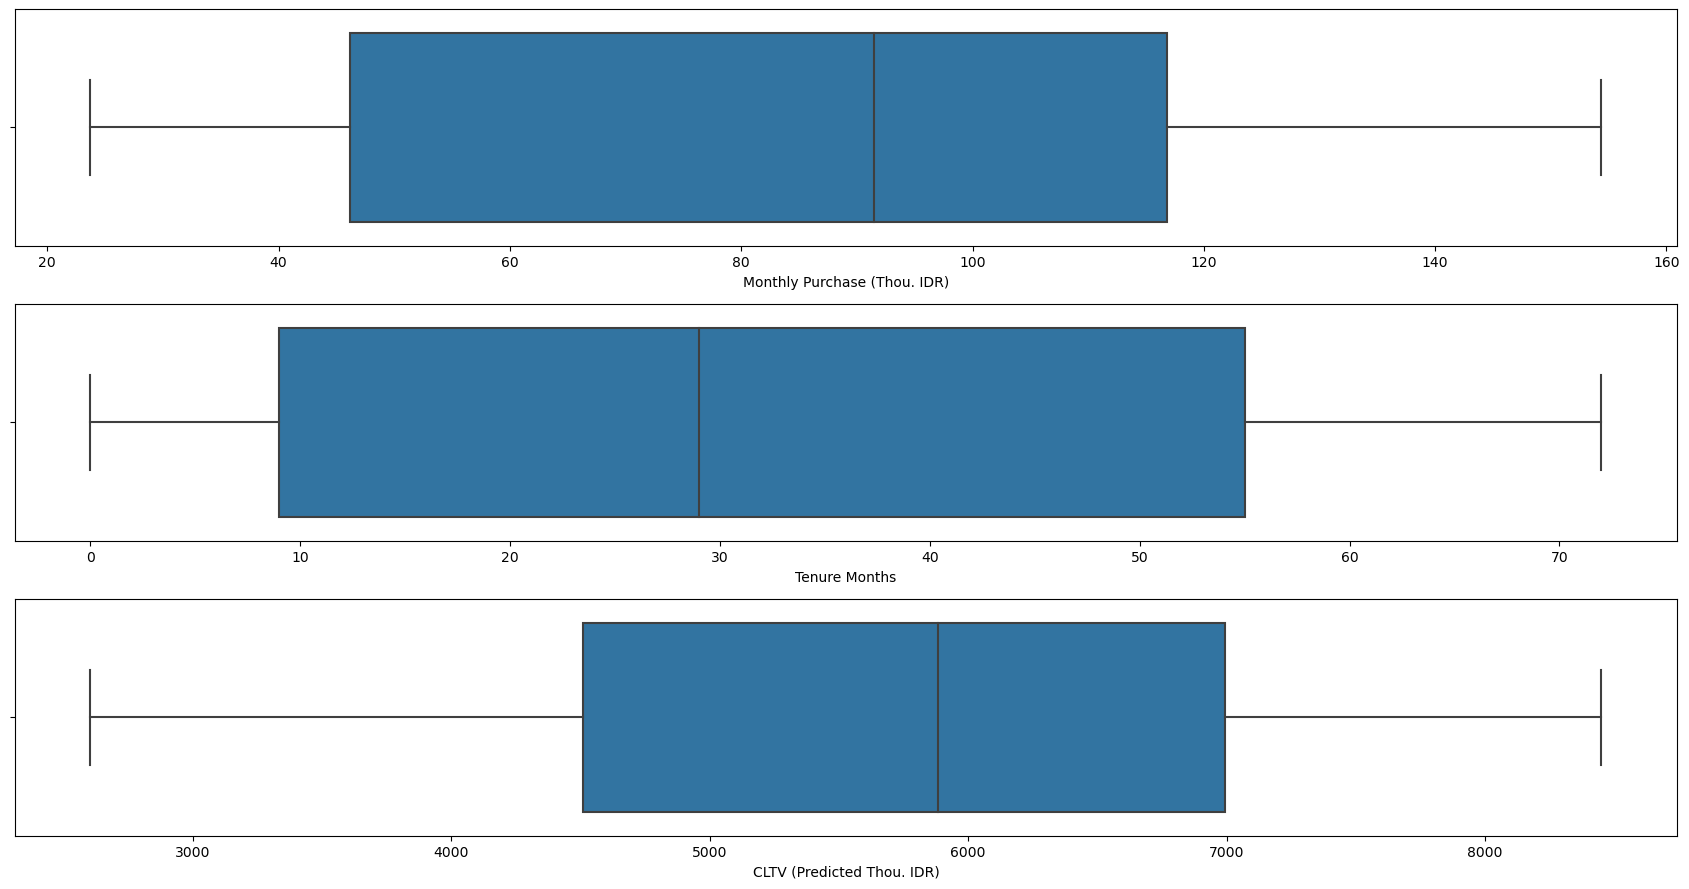

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(17, 9))

for i in range(len(numerical_cols)):
    sns.boxplot(x=df[numerical_cols[i]], ax=axes[i])
    plt.tight_layout()

### Scale Value

In [16]:
df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[numerical_cols] = scaler.fit_transform(df[numerical_cols])

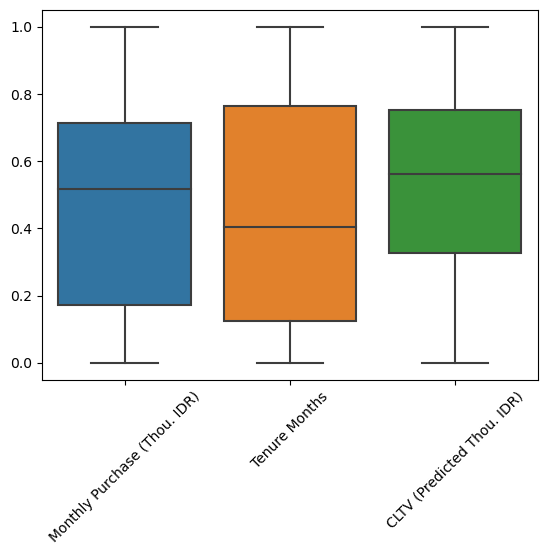

In [17]:
sns.boxplot(df_scaled[numerical_cols], showfliers=True)

# Rotate x-axis labels diagonally
plt.xticks(rotation=45)

# Show the plot
plt.show()

# EDA

## Descriptive Statistics

In [18]:
df.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
Customer ID,7043.000000,3521.000000,2033.283305,0.000000,1760.500000,3521.000000,5281.500000,7042.000000
Tenure Months,7043.000000,32.371149,24.559481,0.000000,9.000000,29.000000,55.000000,72.000000
Monthly Purchase (Thou. IDR),7043.000000,84.190200,39.117061,23.725000,46.150000,91.455000,116.805000,154.375000
Longitude,7043.000000,107.043246,0.358316,106.816666,106.816666,106.816666,107.609810,107.609810
Latitude,7043.000000,-6.404184,0.322898,-6.914744,-6.914744,-6.200000,-6.200000,-6.200000
CLTV (Predicted Thou. IDR),7043.000000,5720.384481,1537.974298,2603.900000,4509.700000,5885.100000,6994.650000,8450.000000


In [19]:
df.describe(exclude=[np.number]).T.style.background_gradient()

,count,unique,top,freq
Location,7043,2,Jakarta,5031
Device Class,7043,3,High End,3096
Games Product,7043,3,No,3498
Music Product,7043,3,No,3088
Education Product,7043,3,No,3095
Call Center,7043,2,No,4999
Video Product,7043,3,No,2810
Use MyApp,7043,3,No,2785
Payment Method,7043,4,Pulsa,2365
Churn Label,7043,2,No,5174


## Univariate Analysis

### Distribution

#### Numerical Features

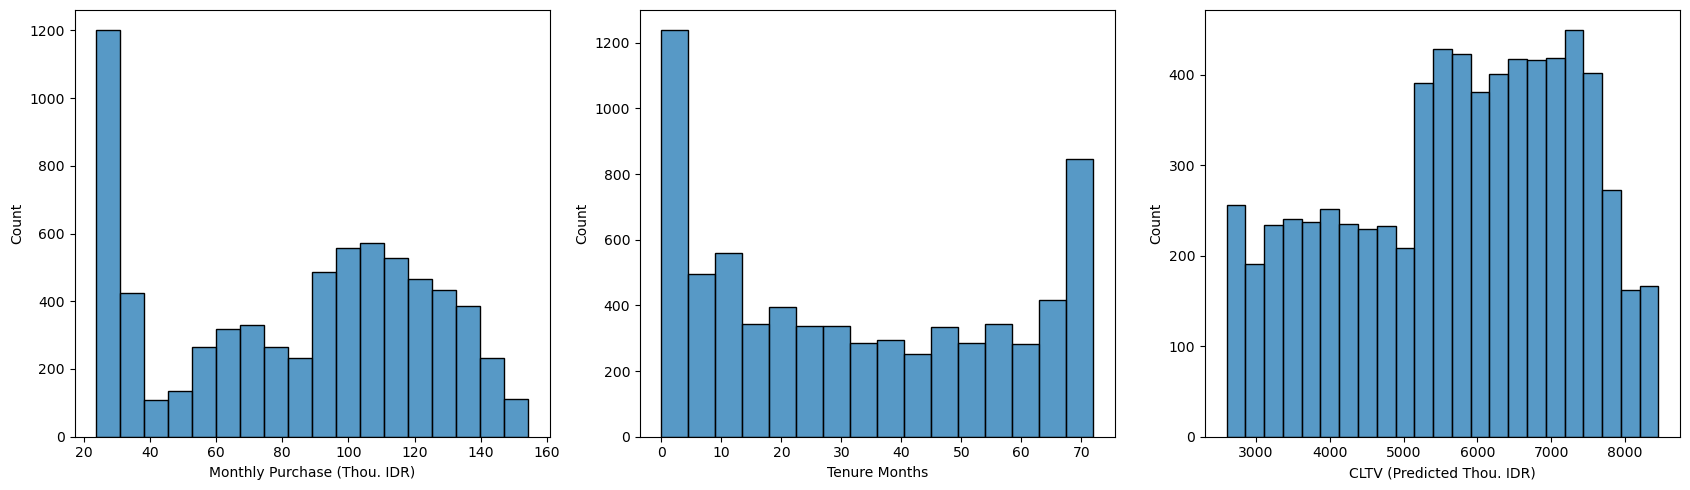

In [20]:
# Create Distplot for Each Numerical Feature
plt.figure(figsize=(17,5))
for i in range(0, len(numerical_cols)):
    plt.subplot(1, 3, i+1)
    sns.histplot(x=df[numerical_cols[i]])
    plt.xlabel(numerical_cols[i])
    plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Monthly Purchase (Thou. IDR)', ylabel='Count'>

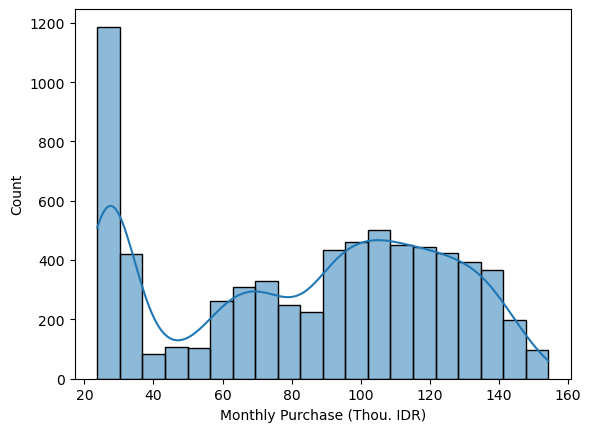

In [21]:
sns.histplot(x=df['Monthly Purchase (Thou. IDR)'], kde=True, bins=20)

#### Categorical Features

In [22]:
cat_cols = df.select_dtypes(include='object').columns
cat_cols

Index(['Location', 'Device Class', 'Games Product', 'Music Product',
       'Education Product', 'Call Center', 'Video Product', 'Use MyApp',
       'Payment Method', 'Churn Label'],
      dtype='object')

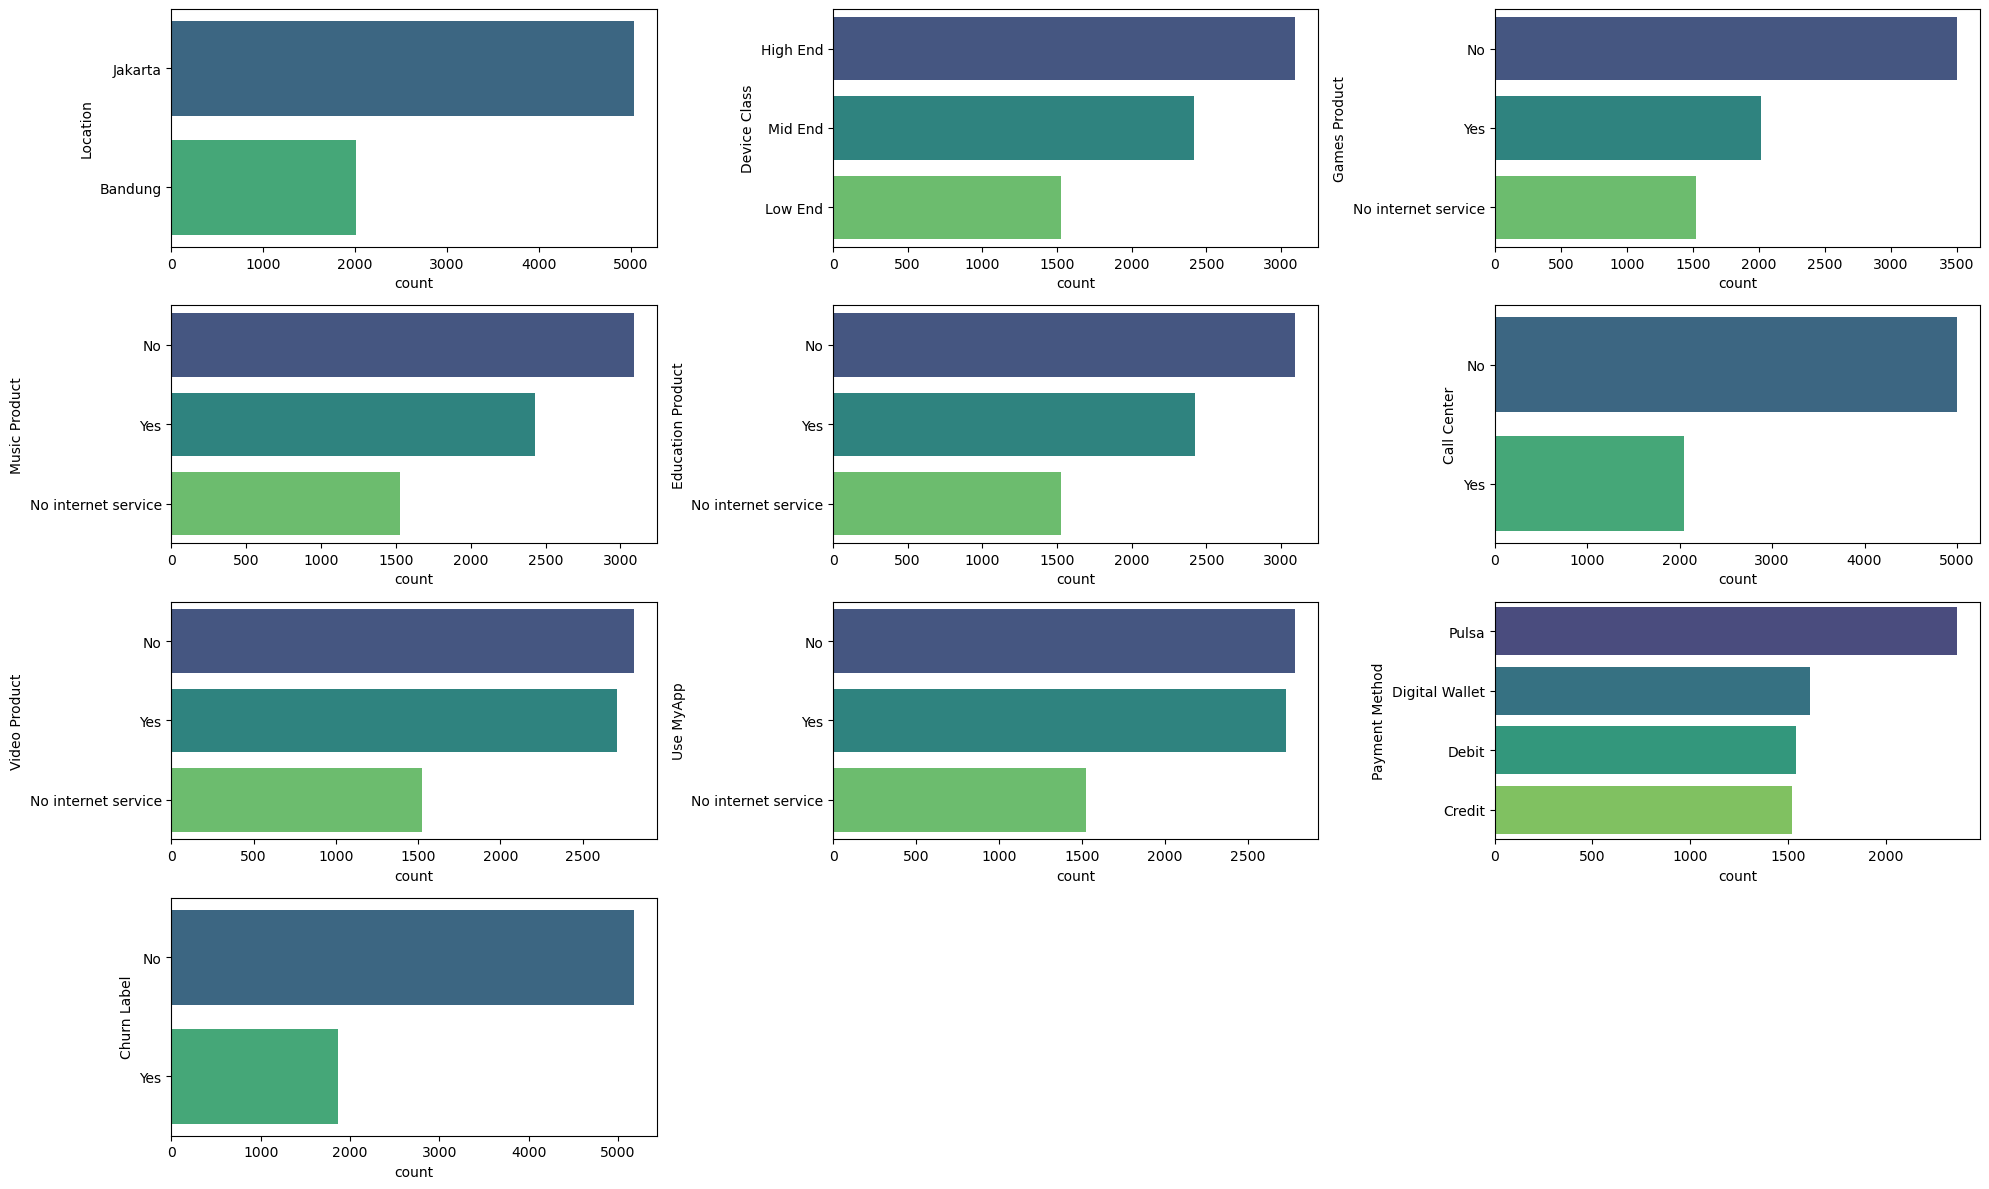

In [23]:
# Create Countplot for Each Categorical Feature
fig, axes = plt.subplots(4, 3, figsize=(20,12))
xy = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2), (3,0), (3,1), (3,2), (4,0)]

for i in range(len(cat_cols)):
    if i == 0:
        sns.countplot(y=df[cat_cols[i]], palette='viridis',ax=axes[xy[i]])
    else:
        sns.countplot(y=df[cat_cols[i]], palette='viridis', order= df[cat_cols[i]].value_counts().index, ax=axes[xy[i]])
axes[3, 1].axis('off')
axes[3, 2].axis('off')
plt.tight_layout()

## Bivariate Analysis

#### Numerical Feature

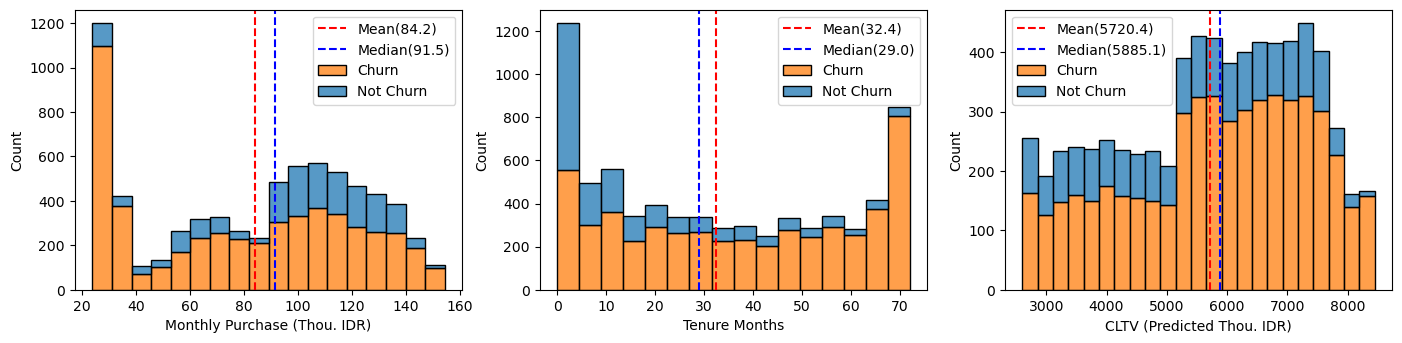

In [24]:
x_text_coor = [35, 5800, 100]
y_text_coor = [800, 450, 800]
# Create Distplot for Each Numerical Feature
plt.figure(figsize=(17,8))
for i in range(0, len(numerical_cols)):
    plt.subplot(2, 3, i+1)
    sns.histplot(x=df[numerical_cols[i]], hue=df['Churn Label'], multiple='stack')
    plt.xlabel(numerical_cols[i])
    
    mean=round(df[numerical_cols[i]].mean(), 1)
    median=round(df[numerical_cols[i]].median(), 1)
    plt.axvline(mean, color='red', linestyle='--') 
    plt.axvline(median, color='blue', linestyle='--') 
    plt.legend(labels=[f'Mean({mean})',f'Median({median})', 'Churn', 'Not Churn'])
    #plt.text(x_text_coor[i], y_text_coor[i], f'mean={mean}', color='red', ha='left', va='top')
    #plt.tight_layout()

In [25]:
df['Tenure Months'].max()

72

In [26]:
pd.cut(df['Tenure Months'], bins=[0, 6, 12, 24, 36, 72]).value_counts()

(36, 72]    3001
(0, 6]      1470
(12, 24]    1024
(24, 36]     832
(6, 12]      705
Name: Tenure Months, dtype: int64

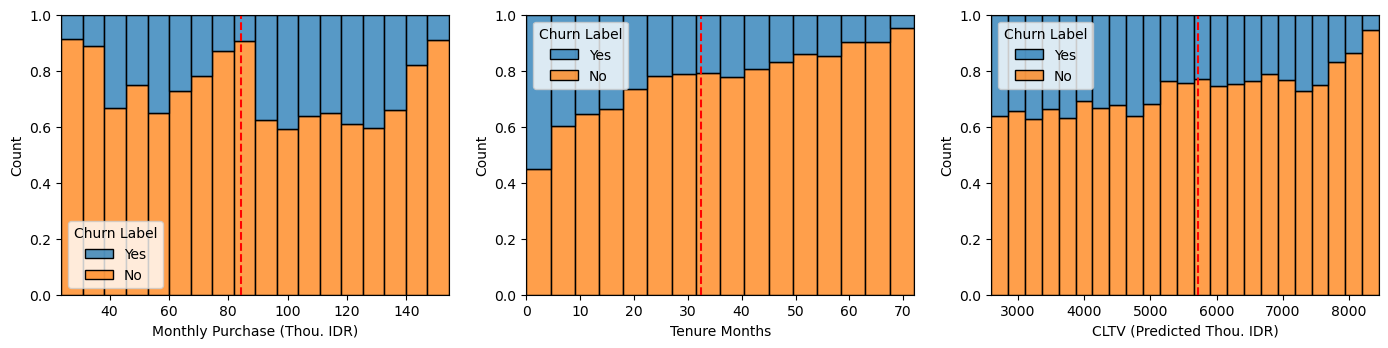

In [27]:
x_text_coor = [35, 5800, 100]
y_text_coor = [800, 450, 800]
# Create Distplot for Each Numerical Feature
plt.figure(figsize=(17,8))
for i in range(0, len(numerical_cols)):
    plt.subplot(2, 3, i+1)
    sns.histplot(x=df[numerical_cols[i]], hue=df['Churn Label'], multiple='fill')
    plt.xlabel(numerical_cols[i])
    
    mean=round(df[numerical_cols[i]].mean(), 1)
    plt.axvline(mean, color='red', linestyle='--') 
    #plt.text(x_text_coor[i], y_text_coor[i], f'mean={mean}', color='red', ha='left', va='top')
    #plt.tight_layout()

#### Categorical Features

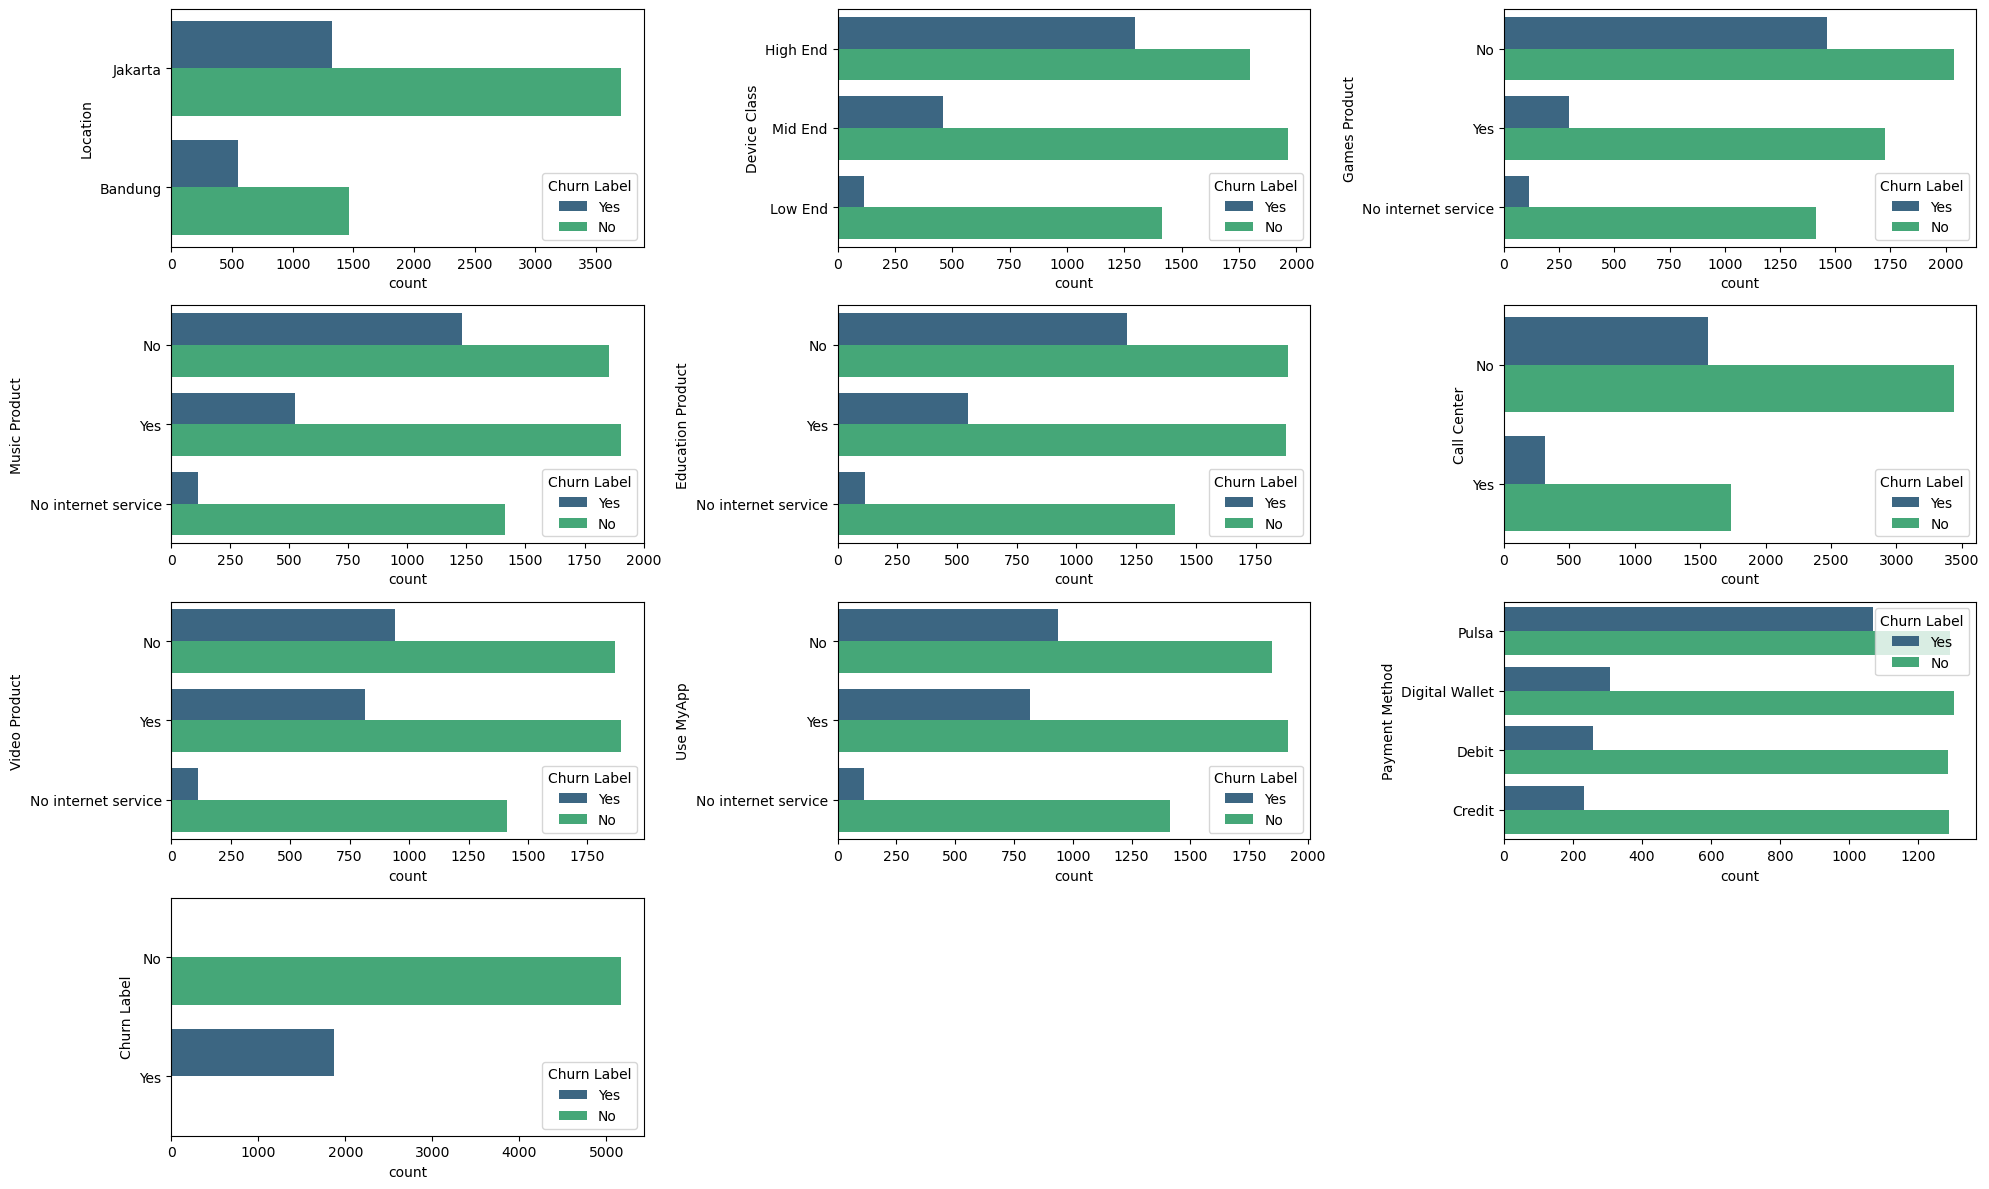

In [28]:
# Create Countplot for Each Categorical Feature
fig, axes = plt.subplots(4, 3, figsize=(20,12))
xy = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2), (3,0), (3,1), (3,2), (4,0)]

for i in range(len(cat_cols)):
    if i == 0:
        sns.countplot(y=df[cat_cols[i]], palette='viridis',ax=axes[xy[i]], hue=df['Churn Label'])
    else:
        sns.countplot(y=df[cat_cols[i]], palette='viridis', order= df[cat_cols[i]].value_counts().index, ax=axes[xy[i]], hue=df['Churn Label'])
axes[3, 1].axis('off')
axes[3, 2].axis('off')
plt.tight_layout()

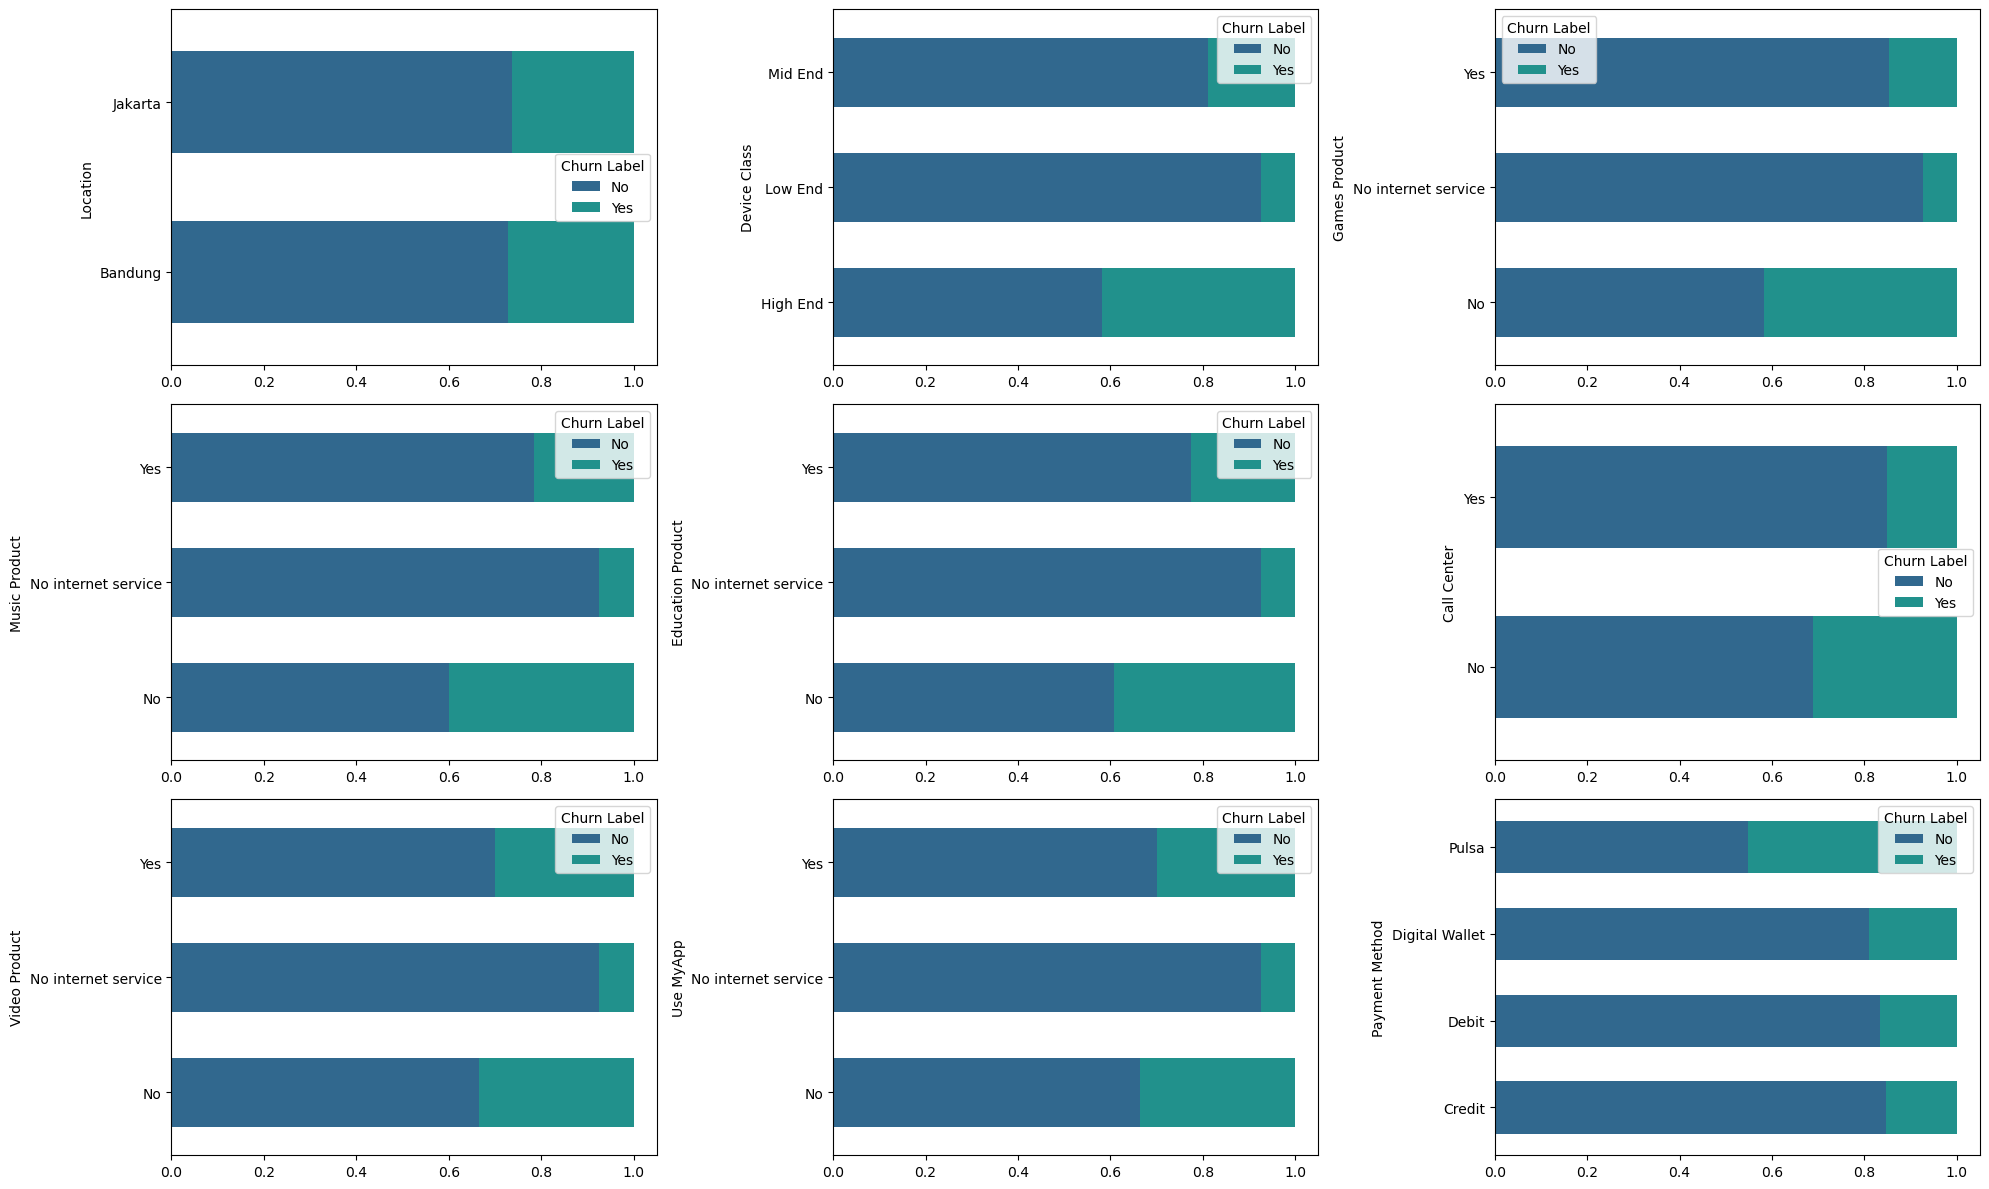

In [29]:
# Create 100% Stacked Bar Chart for Each Categorical Feature
fig, ax = plt.subplots(3, 3, figsize=(20,12))
xy = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2), (3,0), (3,1), (3,2), (4,0)]

for i in range(len(cat_cols)-1):
    sbc = pd.crosstab(df[cat_cols[i]], df['Churn Label'])
    sbc = sbc.div(sbc.sum(axis=1).astype(float), axis=0)
    sbc.plot(kind='barh', stacked=True, color = ['#31688e', '#21918c'], width = 0.6, ax = ax[xy[i]])
    #ax[xy[i]].legend().remove()

plt.tight_layout()
# not_churn = mlp.patches.Patch(color='#31688e', label='Not Churn')
# churn = mlp.patches.Patch(color='#21918c', label='Churn')
# plt.legend(handles=[not_churn, churn], fontsize=14)

## Multivariate Analysis

#### Pair Plot

<Figure size 1500x1500 with 0 Axes>

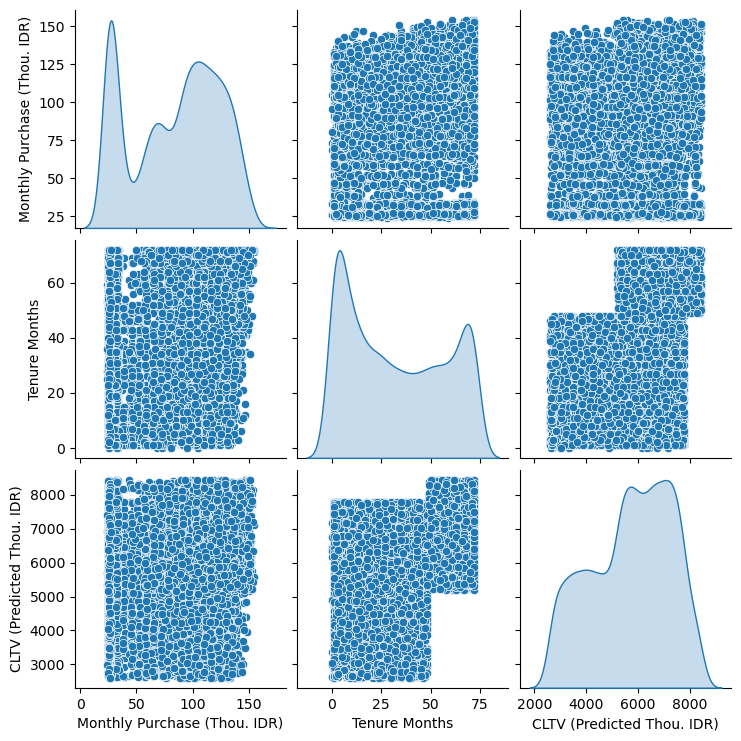

In [30]:
# create pairplot
plt.figure(figsize=(15, 15))
sns.pairplot(df[numerical_cols], diag_kind='kde')

#### Tenure Months vs Payment Methods

Tenure Months	-2.500000	2.500000	0.080000
3	Device Class	2.090000	2.090000	8.090000
6	Payment Method_Pulsa	0.590000	0.590000	1.810000
10	Games Product	-0.460000	0.460000	0.630000
11	Call Center	-0.440000	0.440000	0.640000

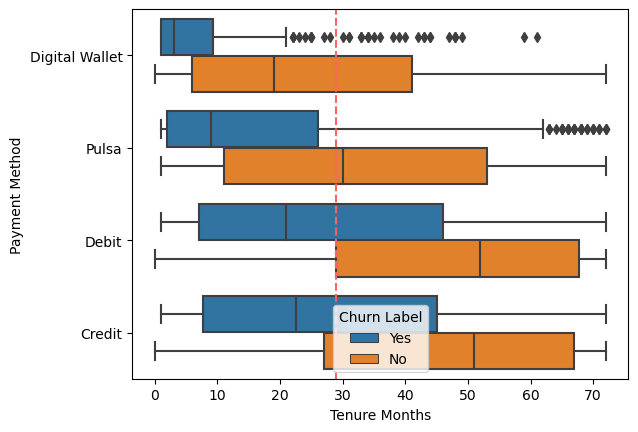

In [31]:
sns.boxplot(data=df, x='Tenure Months', y='Payment Method', hue='Churn Label', orient='h')

plt.axvline(x=df['Tenure Months'].median(), color='#ff6361', ls='--')

<AxesSubplot:xlabel='Tenure Months', ylabel='Call Center'>

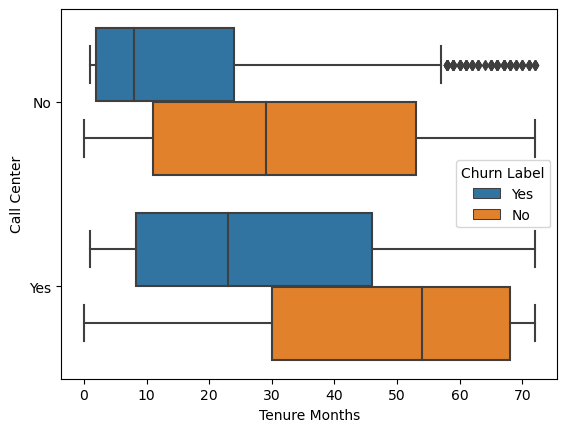

In [32]:
sns.boxplot(data=df, x='Tenure Months', y='Call Center', hue='Churn Label', orient='h')

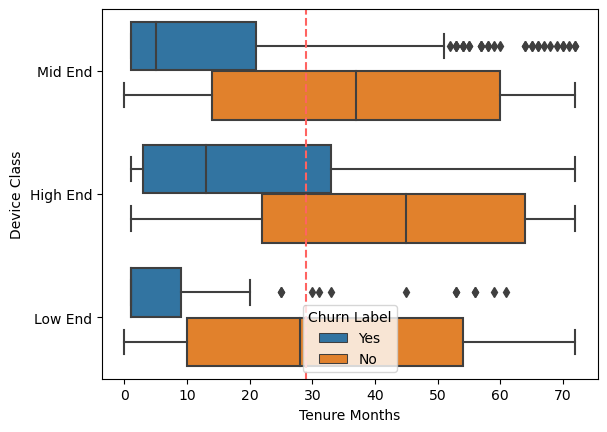

In [33]:
sns.boxplot(data=df, x='Tenure Months', y='Device Class', hue='Churn Label', orient='h')

plt.axvline(x=df['Tenure Months'].median(), color='#ff6361', ls='--')

## Hypothesis Testing

### Categorical Variable 

In [34]:
from scipy.stats import chi2_contingency

#### Chi Square Test for Independence of `Device Class` and `Churn Label`

**Hypotheses:**

$H_0$: There is no significant relationship between the `Device Class` and `Churn Label` variables. In other words, the variables are independent.

$H_A$: There is a significant relationship between the `Device Class` and `Churn Label` variables. In other words, the variables are not independent.

In [35]:
# Create a frequency table
observed_data = pd.crosstab(df['Device Class'], df['Churn Label'])
observed_data

Churn Label,No,Yes
Device Class,,
High End,1799,1297
Low End,1413,113
Mid End,1962,459


In [36]:
_, p_value, _, expected_freq = chi2_contingency(observed_data)
if p_value < 0.05:
    print(f'The p_value {p_value} < 0.05 Accept the H0')
else:
    print(f'The p_value {p_value} >= 0.05 Reject the H0')
print('Expected Frequency:')
print(expected_freq)

The p_value 9.571788222840544e-160 < 0.05 Accept the H0
Expected Frequency:
[[2274.41488002  821.58511998]
 [1121.04557717  404.95442283]
 [1778.53954281  642.46045719]]


This means that the type of device a user uses `Device Class` does not have a significant influence on whether or not they churn `Churn Label`. In simpler terms, it implies that the choice of device (e.g., High End, Mid End, Low End) doesn't play a significant role in determining if a user will churn or not.

#### Chi Square Test for Independence of `Gaming Product` and `Churn Label`

**Hypotheses:**

$H_0$: There is no significant relationship between the `Games Product` and `Churn Label` variables. In other words, the variables are independent.

$H_A$: There is a significant relationship between the `Games Product` and `Churn Label` variables. In other words, the variables are not independent.

In [37]:
# Create a frequency table
observed_data = pd.crosstab(df['Games Product'], df['Churn Label'])
observed_data

Churn Label,No,Yes
Games Product,,
No,2037,1461
No internet service,1413,113
Yes,1724,295


In [38]:
_, p_value, _, expected_freq = chi2_contingency(observed_data)
if p_value < 0.05:
    print(f'The p_value {p_value} < 0.05 Accept the H0')
else:
    print(f'The p_value {p_value} >= 0.05 Reject the H0')
print('Expected Frequency:')
print(expected_freq)

The p_value 2.661149635176552e-185 < 0.05 Accept the H0
Expected Frequency:
[[2569.73619196  928.26380804]
 [1121.04557717  404.95442283]
 [1483.21823087  535.78176913]]


#### Chi Square Test for Independence of `Call Center` and `Churn Label`

**Hypotheses:**

$H_0$: There is no significant relationship between the `Call Center` and `Churn Label` variables. In other words, the variables are independent.

$H_A$: There is a significant relationship between the `Call Center` and `Churn Label` variables. In other words, the variables are not independent.

In [39]:
# Create a frequency table
observed_data = pd.crosstab(df['Call Center'], df['Churn Label'])
observed_data

Churn Label,No,Yes
Call Center,,
No,3440,1559
Yes,1734,310


In [40]:
_, p_value, _, expected_freq = chi2_contingency(observed_data)
if p_value < 0.05:
    print(f'The p_value {p_value} < 0.05 Accept the H0')
else:
    print(f'The p_value {p_value} >= 0.05 Reject the H0')
print('Expected Frequency:')
print(expected_freq)

The p_value 2.9235674453140758e-43 < 0.05 Accept the H0
Expected Frequency:
[[3672.4160159 1326.5839841]
 [1501.5839841  542.4160159]]


#### Chi Square Test for Independence of `Payment Method` and `Churn Label`

**Hypotheses:**

$H_0$: There is no significant relationship between the `Payment Method` and `Churn Label` variables. In other words, the variables are independent.

$H_A$: There is a significant relationship between the `Payment Method` and `Churn Label` variables. In other words, the variables are not independent.

In [41]:
# Create a frequency table
observed_data = pd.crosstab(df['Payment Method'], df['Churn Label'])
observed_data

Churn Label,No,Yes
Payment Method,,
Credit,1290,232
Debit,1286,258
Digital Wallet,1304,308
Pulsa,1294,1071


In [42]:
_, p_value, _, expected_freq = chi2_contingency(observed_data)
if p_value < 0.05:
    print(f'The p_value {p_value} < 0.05 Accept the H0')
else:
    print(f'The p_value {p_value} >= 0.05 Reject the H0')
print('Expected Frequency:')
print(expected_freq)

The p_value 3.6823546520097993e-140 < 0.05 Accept the H0
Expected Frequency:
[[1118.10705665  403.89294335]
 [1134.26891949  409.73108051]
 [1184.22376828  427.77623172]
 [1737.40025557  627.59974443]]


In [43]:
Observations = np.array([[1290, 232], [1294, 1071]])
Result = chi2_contingency(Observations)
print(Result)

Chi2ContingencyResult(statistic=373.70389620692004, pvalue=2.922481649208432e-83, dof=1, expected_freq=array([[1011.79521482,  510.20478518],
       [1572.20478518,  792.79521482]]))


In [44]:
Observations = np.array([[1118, 403], [1737, 627]])
Result = chi2_contingency(Observations)
print(Result)

Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=1, expected_freq=array([[1117.74903475,  403.25096525],
       [1737.25096525,  626.74903475]]))


# Discovering

#### Segment on CLTV > 5150 and Tenure Month > 48

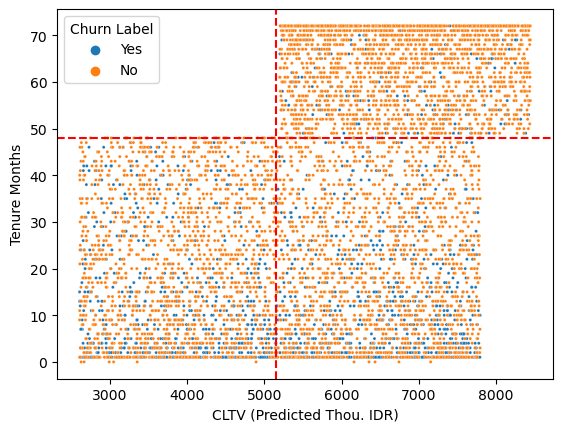

In [45]:
sns.scatterplot(x='CLTV (Predicted Thou. IDR)', y='Tenure Months', data=df, hue='Churn Label', s=5)
plt.axvline(5150, color='red', linestyle='--') 
plt.axhline(48, color='red', linestyle='--') 

In [46]:
mask = ((df['CLTV (Predicted Thou. IDR)'] > 5150) & (df['Tenure Months'] > 48))
disc_cltv = df[mask]
disc_cltv.sample(5)

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
6815,6815,49,Jakarta,Mid End,No,Yes,No,Yes,Yes,Yes,Debit,103.090,No,106.816666,-6.200000,8275.8
6144,6144,72,Jakarta,High End,No,Yes,Yes,Yes,Yes,Yes,Pulsa,140.920,No,106.816666,-6.200000,5712.2
4099,4099,59,Jakarta,Mid End,Yes,Yes,Yes,Yes,Yes,Yes,Pulsa,112.775,No,106.816666,-6.200000,6526.0
4989,4989,69,Bandung,Mid End,Yes,Yes,No,Yes,Yes,Yes,Debit,104.845,No,107.609810,-6.914744,6003.4
4778,4778,72,Jakarta,High End,No,Yes,Yes,Yes,Yes,Yes,Credit,140.465,No,106.816666,-6.200000,7059.0


In [47]:
df[df['Games Product'] == 'No'].head(5)

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0
5,5,10,Jakarta,Mid End,No,No,Yes,Yes,No,No,Credit,71.760,Yes,106.816666,-6.2,7702.5


In [48]:
df[df['Games Product'] == 'Yes'].sample(5)

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
2190,2190,68,Jakarta,Mid End,Yes,No,No,Yes,No,No,Debit,75.725,No,106.816666,-6.2,6006.0
5140,5140,70,Jakarta,Mid End,Yes,Yes,Yes,Yes,Yes,No,Debit,103.610,No,106.816666,-6.2,6302.4
2172,2172,60,Jakarta,High End,Yes,No,Yes,No,Yes,No,Debit,124.020,No,106.816666,-6.2,5393.7
5119,5119,46,Jakarta,High End,Yes,Yes,No,Yes,Yes,Yes,Pulsa,143.260,No,106.816666,-6.2,5410.6
2775,2775,30,Jakarta,High End,Yes,Yes,Yes,No,No,No,Debit,117.520,No,106.816666,-6.2,4122.3


In [49]:
#disc_cltv.to_csv('Telco_CLTV_High_Segment.csv', index=False)

#### Monthly Purchse > 89.000

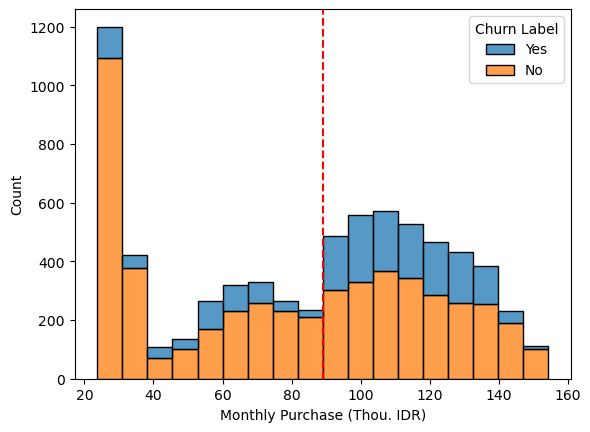

In [50]:
sns.histplot(x=df['Monthly Purchase (Thou. IDR)'], hue=df['Churn Label'], multiple='stack')
plt.xlabel('Monthly Purchase (Thou. IDR)')
plt.axvline(89, color='red', linestyle='--') 

In [51]:
df['Games Product'].unique()

array(['Yes', 'No', 'No internet service'], dtype=object)

In [52]:
disc_purchase = df[df['Monthly Purchase (Thou. IDR)'] > 89]

In [53]:
disc_purchase['Games Product'].unique()

array(['No', 'Yes'], dtype=object)

In [54]:
df[df['Monthly Purchase (Thou. IDR)'] < 27].shape[0]

1118

In [55]:
df[df['Monthly Purchase (Thou. IDR)'] < 150].shape[0]

6991

In [56]:
df[df['Monthly Purchase (Thou. IDR)'] > 150].shape[0]

52

In [57]:
#disc_purchase.to_csv('Telco_MonthlyPurchase_HighSegment.csv', index=False)

# Feature Engineering

In [58]:
df.select_dtypes(exclude='object').columns

Index(['Customer ID', 'Tenure Months', 'Monthly Purchase (Thou. IDR)',
       'Longitude', 'Latitude', 'CLTV (Predicted Thou. IDR)'],
      dtype='object')

### **More Features**
- Average Monthly Purchase: (Monthly Purchase / Tenure Months)
- Total Purchase: Monthly Purchase * Tenure Months
- Number of Product Used (Range from 0 to 4)
- Decrease Product value from (Yes, No, No Internet Service) to only (Yes, No) or only whether the customer use telkomsel product or no. This is simplify the interpretation

In [59]:
df['Total Purchase']= df['Monthly Purchase (Thou. IDR)'] * df['Tenure Months']


df['Num Product Used'] = (df[['Games Product', 'Music Product', 'Education Product', 'Video Product']]
                        .replace({'Yes': 1, 'No': 0, 'No internet service': 0}).sum(axis=1))

In [60]:
df['Num Product Used'].value_counts()

0    2535
2    1471
1    1470
3    1103
4     464
Name: Num Product Used, dtype: int64

In [61]:
df.shape

(7043, 18)

In [62]:
#df.to_csv('Telco_Customer_Engineeredv1.csv', index=False)

#### Handling Outliers in Average Purchase Per Product Used

In [63]:
# plt.figure(figsize=(10, 2))
# sns.boxplot(x=df['Average Purchase Per Product Used'])

In [64]:
# plt.figure(figsize=(10, 2))
# sns.boxplot(x=np.log(df['Average Purchase Per Product Used']))

###### Floring at quantile

In [65]:
# # Calculate 10th percentile
# tenth_percentile = np.percentile(df['Average Purchase Per Product Used'], 10)

# # Calculate 90th percentile
# ninetieth_percentile = np.percentile(df['Average Purchase Per Product Used'], 90)

# # Apply lambda function to replace outliers with thresholds defined above
# df['Average Purchase Per Product Used'] = df['Average Purchase Per Product Used'].apply(lambda x: (
#     tenth_percentile if x < tenth_percentile 
#     else ninetieth_percentile if x > ninetieth_percentile 
#     else x))

In [66]:
# plt.figure(figsize=(10, 2))
# sns.boxplot(x=df['Average Purchase Per Product Used'])

### Feature Transformation
- Products from Yes, No, No Internet Service to only Yes and No

In [67]:
df['Internet Access'] = df['Games Product'].replace({'No': 'Yes', 'No internet service': 'No'})

df['Games Product'].replace({'No internet service': 'No'}, inplace=True)
df['Music Product'].replace({'No internet service': 'No'}, inplace=True)
df['Education Product'].replace({'No internet service': 'No'}, inplace=True)
df['Video Product'].replace({'No internet service': 'No'}, inplace=True)
df['Use MyApp'].replace({'No internet service': 'No'}, inplace=True)

In [68]:
df.columns

Index(['Customer ID', 'Tenure Months', 'Location', 'Device Class',
       'Games Product', 'Music Product', 'Education Product', 'Call Center',
       'Video Product', 'Use MyApp', 'Payment Method',
       'Monthly Purchase (Thou. IDR)', 'Churn Label', 'Longitude', 'Latitude',
       'CLTV (Predicted Thou. IDR)', 'Total Purchase', 'Num Product Used',
       'Internet Access'],
      dtype='object')

In [69]:
df['Internet Access'].value_counts()

Yes    5517
No     1526
Name: Internet Access, dtype: int64

In [70]:
df[df['Payment Method'] == 'Pulsa']['Internet Access'].value_counts(normalize=True)

Yes    0.948414
No     0.051586
Name: Internet Access, dtype: float64

In [71]:
df['Device Class'].value_counts()

High End    3096
Mid End     2421
Low End     1526
Name: Device Class, dtype: int64

In [72]:
#df.to_csv('Telco_Customer_Engineeredv2.csv', index=False)

#### Correlation Heatmap

In [73]:
numerical_cols = list(set(df.select_dtypes(exclude='object').columns)-set(['Customer ID', 'Longitude', 'Latitude']))
numerical_cols

['Tenure Months',
 'Num Product Used',
 'Monthly Purchase (Thou. IDR)',
 'Total Purchase',
 'CLTV (Predicted Thou. IDR)']

<AxesSubplot:>

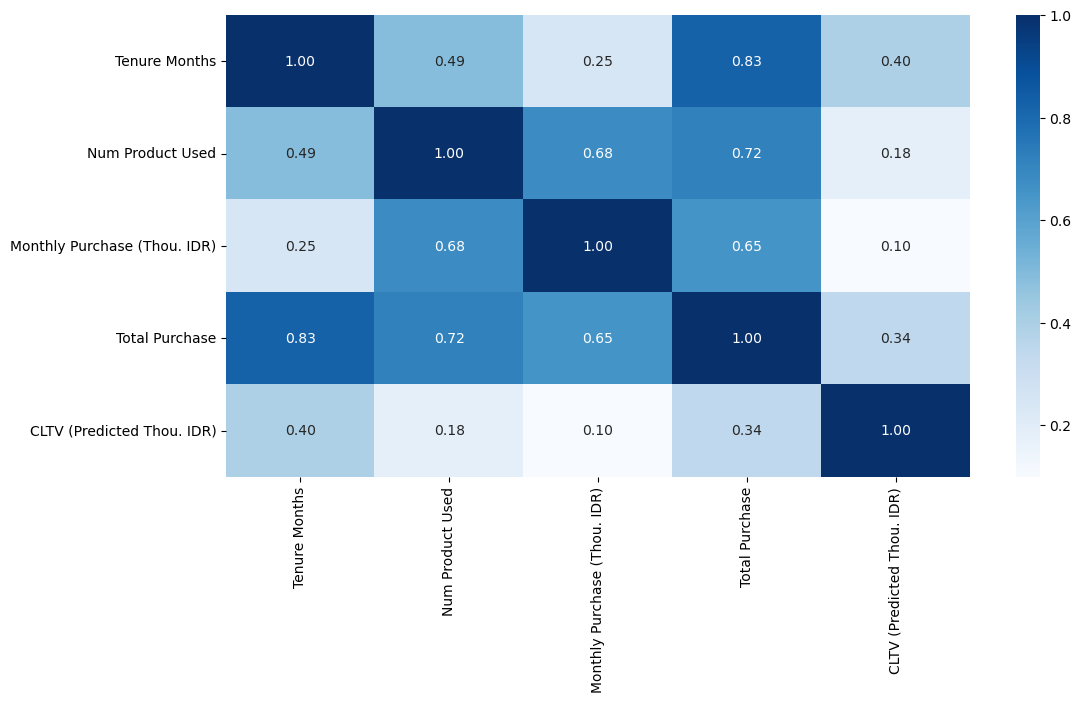

In [74]:
# Create Heatmap Correlation Chart for Each Numerical Features
plt.figure(figsize=(12, 6))
sns.heatmap(df[numerical_cols].corr(), cmap='Blues', annot=True, fmt='.2f')

In [75]:
# Assuming df is your DataFrame
high_correlation_features = []

correlation_matrix = df[numerical_cols].corr().abs()
high_correlation_pairs = (correlation_matrix > 0.7) & (correlation_matrix < 1.0)
 
for feature in high_correlation_pairs.columns:
    correlated_features = high_correlation_pairs.index[high_correlation_pairs[feature]].tolist()
    high_correlation_features.extend([(feature, corr_feature) for corr_feature in correlated_features])

high_correlation_features = list(set(high_correlation_features))

print(high_correlation_features)

[('Total Purchase', 'Num Product Used'), ('Tenure Months', 'Total Purchase'), ('Total Purchase', 'Tenure Months'), ('Num Product Used', 'Total Purchase')]


Total purchase and Tenure Months introduce multicollinearity so we won't used it for our model.

#### Correlation Heatmap with Target Features

<AxesSubplot:>

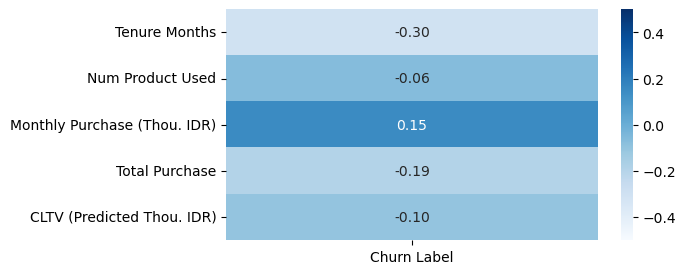

In [76]:
label_num = df['Churn Label'].replace({'Yes': 1, 'No': 0})
data = pd.concat([df[numerical_cols], label_num], axis=1)

plt.figure(figsize=(6, 3))
(sns.heatmap(data.corr(method = 'kendall')
            [data.corr(method='kendall')
             .index != 'Churn Label'][['Churn Label']], 
            annot=True,
           cmap='Blues',
            fmt='.2f',
            vmin=-0.5,
            vmax=0.5))

### **Non Linearity Problem**
- Monthly Purchase -> Squared Monthly Purchase
- CLTV -> Squared CLTV

In [77]:
# df['Square Monthly Purchase'] = df['Monthly Purchase (Thou. IDR)']**2
# df['Square CLTV'] = df['CLTV (Predicted Thou. IDR)']**2

#df['Log CLTV (Predicted Thou. IDR)'] = np.log(df['CLTV (Predicted Thou. IDR)'])

In [78]:
df.columns

Index(['Customer ID', 'Tenure Months', 'Location', 'Device Class',
       'Games Product', 'Music Product', 'Education Product', 'Call Center',
       'Video Product', 'Use MyApp', 'Payment Method',
       'Monthly Purchase (Thou. IDR)', 'Churn Label', 'Longitude', 'Latitude',
       'CLTV (Predicted Thou. IDR)', 'Total Purchase', 'Num Product Used',
       'Internet Access'],
      dtype='object')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4356\3226963147.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='.2f')


<AxesSubplot:>

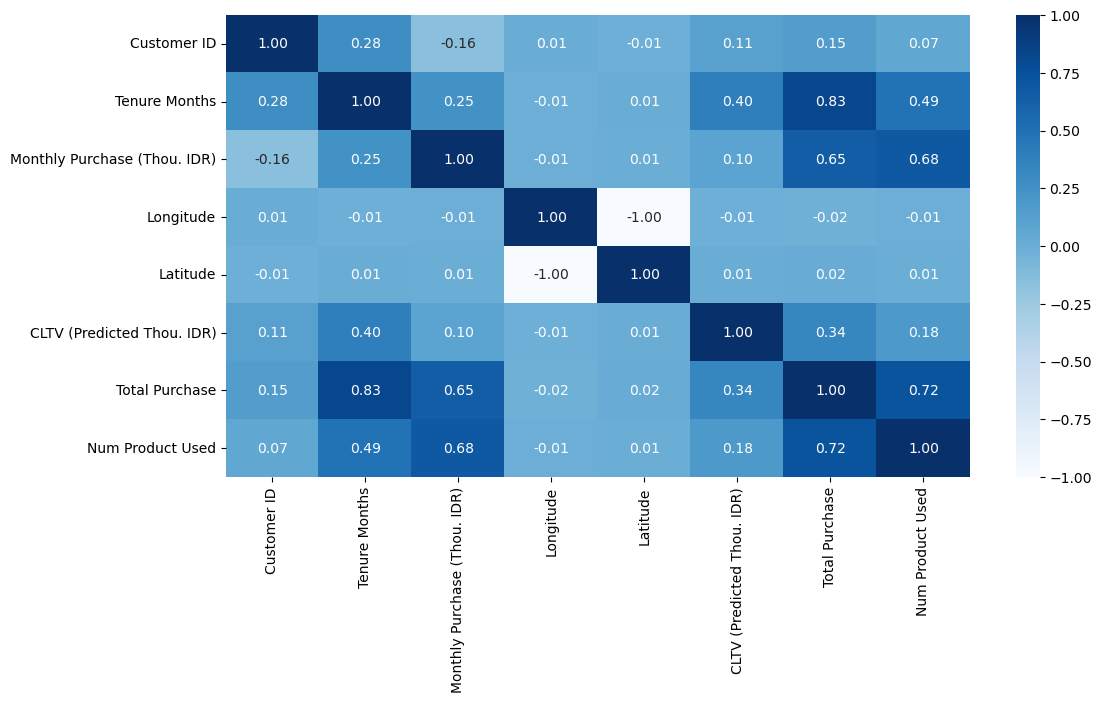

In [79]:
# Create Heatmap Correlation Chart for Each Numerical Features
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='.2f')

# Modeling

### Encoding Categorical Variables

In [80]:
numerical_cols = (list(set(df.select_dtypes(exclude='object').columns)-
                      set(['Customer ID', 'Longitude', 'Latitude', 'Total Purchase'])))
numerical_cols

['Monthly Purchase (Thou. IDR)',
 'Num Product Used',
 'Tenure Months',
 'CLTV (Predicted Thou. IDR)']

In [81]:
df[numerical_cols].describe()

,Monthly Purchase (Thou. IDR),Num Product Used,Tenure Months,CLTV (Predicted Thou. IDR)
count,7043.000000,7043.00000,7043.000000,7043.000000
mean,84.190200,1.35979,32.371149,5720.384481
std,39.117061,1.28800,24.559481,1537.974298
min,23.725000,0.00000,0.000000,2603.900000
25%,46.150000,0.00000,9.000000,4509.700000
50%,91.455000,1.00000,29.000000,5885.100000
75%,116.805000,2.00000,55.000000,6994.650000
max,154.375000,4.00000,72.000000,8450.000000


#### Ordinal Encoding

In [82]:
categorical_encoded_ord = (df['Device Class'].map({'Low End': 0,
                                                  'Mid End': 1,
                                                  'High End': 2}))

In [83]:
categorical_encoded_ord.value_counts()

2    3096
1    2421
0    1526
Name: Device Class, dtype: int64

In [84]:
3096+2421

5517

#### One Hot Encoding

In [85]:
cat_cols = df.select_dtypes(include='object').columns
cat_cols

Index(['Location', 'Device Class', 'Games Product', 'Music Product',
       'Education Product', 'Call Center', 'Video Product', 'Use MyApp',
       'Payment Method', 'Churn Label', 'Internet Access'],
      dtype='object')

In [86]:
# exclude binary columns
sub_cat_cols = list(set(cat_cols)-set(['Device Class', 'Churn Label', 'Games Product', 
                                       'Video Product', 'Education Product', 'Video Product', 
                                       'Music Product', 'Use MyApp', 'Call Center', 'Location','Internet Access']))
categorical_encoded_nom = pd.get_dummies(df[sub_cat_cols], drop_first=True)

In [87]:
categorical_encoded_nom.columns.unique()

Index(['Payment Method_Debit', 'Payment Method_Digital Wallet',
       'Payment Method_Pulsa'],
      dtype='object')

#### Binary Encoding

In [88]:
binary_cols = ['Churn Label', 'Games Product', 'Video Product', 
                  'Education Product', 'Music Product', 
                  'Use MyApp', 'Call Center', 'Internet Access']

binary_encoded = df[binary_cols].replace({'Yes': 1, 'No': 0})

Combine all the encoded variables.

In [89]:
df_final = pd.concat([df[numerical_cols], categorical_encoded_ord, categorical_encoded_nom, binary_encoded], axis=1)
df_final.columns

Index(['Monthly Purchase (Thou. IDR)', 'Num Product Used', 'Tenure Months',
       'CLTV (Predicted Thou. IDR)', 'Device Class', 'Payment Method_Debit',
       'Payment Method_Digital Wallet', 'Payment Method_Pulsa', 'Churn Label',
       'Games Product', 'Video Product', 'Education Product', 'Music Product',
       'Use MyApp', 'Call Center', 'Internet Access'],
      dtype='object')

In [90]:
df_final.shape

(7043, 16)

In [91]:
df_final['Internet Access'].value_counts()

1    5517
0    1526
Name: Internet Access, dtype: int64

### Check Multicollinearity

<AxesSubplot:>

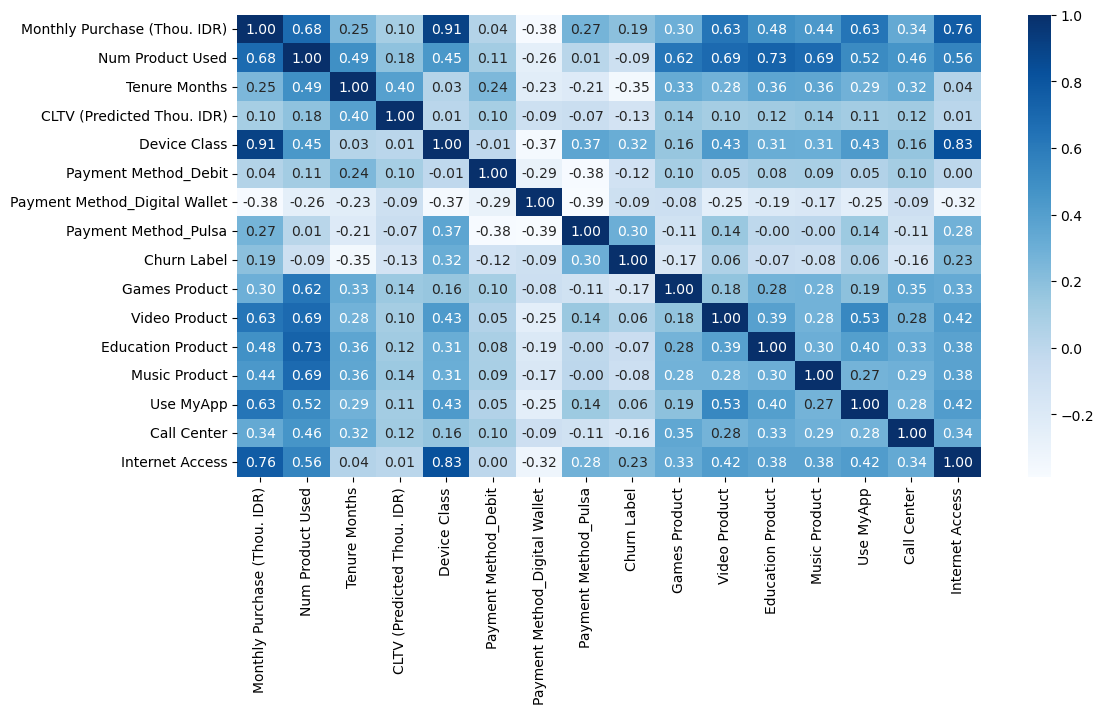

In [92]:
# Create Heatmap Correlation Chart for Each Numerical Features
plt.figure(figsize=(12, 6))
sns.heatmap(df_final.corr(), cmap='Blues', annot=True, fmt='.2f')

In [93]:
# Assuming df is your DataFrame
high_correlation_features = []

correlation_matrix = df_final.corr().abs()
high_correlation_pairs = (correlation_matrix > 0.7) & (correlation_matrix < 1.0)
 
for feature in high_correlation_pairs.columns:
    correlated_features = high_correlation_pairs.index[high_correlation_pairs[feature]].tolist()
    high_correlation_features.extend([(feature, corr_feature) for corr_feature in correlated_features])

high_correlation_features = list(set(high_correlation_features))

print(high_correlation_features)

[('Monthly Purchase (Thou. IDR)', 'Device Class'), ('Internet Access', 'Device Class'), ('Monthly Purchase (Thou. IDR)', 'Internet Access'), ('Device Class', 'Monthly Purchase (Thou. IDR)'), ('Education Product', 'Num Product Used'), ('Device Class', 'Internet Access'), ('Internet Access', 'Monthly Purchase (Thou. IDR)'), ('Num Product Used', 'Education Product')]


 'Monthly Purchase (Thou. IDR)', 'Internet Access', 'Education Product'

In [94]:
numerical_cols = set(numerical_cols) - set(['Monthly Purchase (Thou. IDR)'])
binary_cols = set(binary_cols) - set(['Internet Access', 'Education Product'])


df_final = pd.concat([df[numerical_cols], categorical_encoded_ord, categorical_encoded_nom, binary_encoded[binary_cols]], axis=1)
df_final.columns

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4356\1853542558.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_final = pd.concat([df[numerical_cols], categorical_encoded_ord, categorical_encoded_nom, binary_encoded[binary_cols]], axis=1)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4356\1853542558.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_final = pd.concat([df[numerical_cols], categorical_encoded_ord, categorical_encoded_nom, binary_encoded[binary_cols]], axis=1)


Index(['Num Product Used', 'Tenure Months', 'CLTV (Predicted Thou. IDR)',
       'Device Class', 'Payment Method_Debit', 'Payment Method_Digital Wallet',
       'Payment Method_Pulsa', 'Music Product', 'Video Product',
       'Games Product', 'Churn Label', 'Use MyApp', 'Call Center'],
      dtype='object')

<AxesSubplot:>

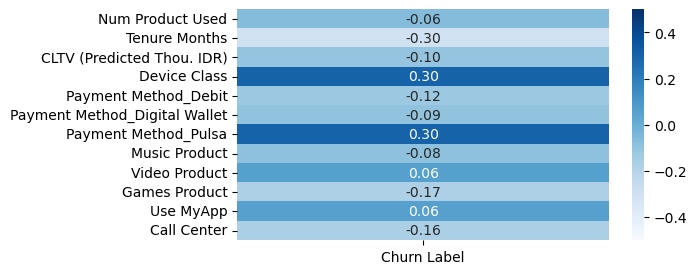

In [95]:
label_num = df['Churn Label'].replace({'Yes': 1, 'No': 0})
data = pd.concat([df_final.drop(columns='Churn Label', axis=1), label_num], axis=1)

plt.figure(figsize=(6, 3))
(sns.heatmap(data.corr(method = 'kendall')
            [data.corr(method='kendall')
             .index != 'Churn Label'][['Churn Label']], 
            annot=True,
           cmap='Blues',
            fmt='.2f',
            vmin=-0.5,
            vmax=0.5))

In [96]:
df_final.shape

(7043, 13)

[]


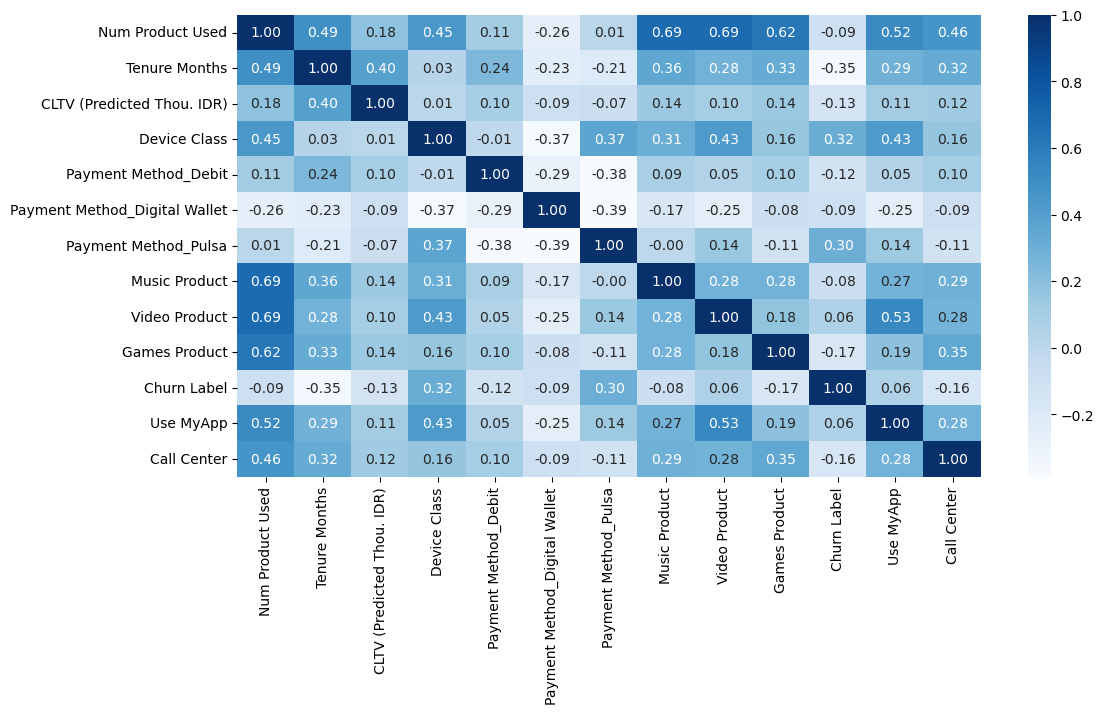

In [97]:
# Create Heatmap Correlation Chart for Each Numerical Features
plt.figure(figsize=(12, 6))
sns.heatmap(df_final.corr(), cmap='Blues', annot=True, fmt='.2f')

# Check multicollinearity
high_correlation_features = []

correlation_matrix = df_final.corr().abs()
high_correlation_pairs = (correlation_matrix > 0.7) & (correlation_matrix < 1.0)
 
for feature in high_correlation_pairs.columns:
    correlated_features = high_correlation_pairs.index[high_correlation_pairs[feature]].tolist()
    high_correlation_features.extend([(feature, corr_feature) for corr_feature in correlated_features])

high_correlation_features = list(set(high_correlation_features))

print(high_correlation_features)

In [98]:
df_final.columns

Index(['Num Product Used', 'Tenure Months', 'CLTV (Predicted Thou. IDR)',
       'Device Class', 'Payment Method_Debit', 'Payment Method_Digital Wallet',
       'Payment Method_Pulsa', 'Music Product', 'Video Product',
       'Games Product', 'Churn Label', 'Use MyApp', 'Call Center'],
      dtype='object')

In [99]:
# df_final_with_id = pd.concat([df['Customer ID'], df[numerical_cols], categorical_encoded_ord, categorical_encoded_nom, binary_encoded], axis=1)
# df_final_with_id.columns

In [100]:
# df_final_with_id.to_csv('Telco_Customer_Engineeredv1_Encoded.csv', index=False)

In [101]:
#df_final.to_csv('Sub_Telco_Encoded.csv', index=False)

### Train-Test Split

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [146]:
X= df_final.drop(columns='Churn Label', axis=1)
y= df_final['Churn Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [223]:
X_train.shape

(4930, 12)

In [224]:
X_test.shape

(2113, 12)

In [147]:
X.columns

Index(['Num Product Used', 'Tenure Months', 'CLTV (Predicted Thou. IDR)',
       'Device Class', 'Payment Method_Debit', 'Payment Method_Digital Wallet',
       'Payment Method_Pulsa', 'Music Product', 'Video Product',
       'Games Product', 'Use MyApp', 'Call Center'],
      dtype='object')

In [148]:
X.shape

(7043, 12)

In [149]:
y_train.value_counts()

0    3622
1    1308
Name: Churn Label, dtype: int64

In [150]:
y_test.value_counts()

0    1552
1     561
Name: Churn Label, dtype: int64

### Scaling

In [151]:
scaler= MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [152]:
# # Save Model
# path = './output'
# with open(path+'/scaler.pickle', 'wb') as to_write:
#     pickle.dump(scaler, to_write)

### SMOTE

In [188]:
from imblearn.over_sampling import SMOTE

In [189]:
# Random Over Sampling
sm = SMOTE(sampling_strategy=0.45, random_state=42)
sm.fit(X_train_scaled, y_train)
X_smote, y_smote = sm.fit_resample(X_train_scaled, y_train)

In [190]:
y_train.value_counts()

0    3622
1    1308
Name: Churn Label, dtype: int64

In [191]:
y_smote.value_counts()

0    3622
1    1629
Name: Churn Label, dtype: int64

In [192]:
def not_using_smote():
    X_smote = X_train_scaled
    y_smote = y_train

not_using_smote()

### Modeling

In [193]:
# Import Metrics Evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix, classification_report, roc_auc_score, make_scorer

# Import Models

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [194]:
# Create Modeling Function
def createmodel(x_train, x_test, y_train, y_test, models):
    performance = []
    for i in models:
        model = i
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        y_train_pred = model.predict(x_train)
        performance.append([np.round(precision_score(y_train, y_train_pred, pos_label=1),3), np.round(precision_score(y_test, y_pred, pos_label=1),3),
                           np.round(recall_score(y_train, y_train_pred, pos_label=1),3), np.round(recall_score(y_test, y_pred, pos_label=1),3),
                            np.round(f1_score(y_train, y_train_pred, pos_label=1),3), np.round(f1_score(y_test, y_pred, pos_label=1),3)
                           ])
    
    print(performance)
    performance_df = pd.DataFrame(data=performance, columns='Train\nPrecision,Test\nPrecision,Train\nRecall,Test\nRecall,Train\nF1 Score,Test\nF1 Score'.split(","),
                                index=[str(type(clf).__name__) + '()' for clf in models])
    plt.figure(figsize=(18, 9))
    sns.heatmap(performance_df, annot=True, cmap="Blues", annot_kws={"fontsize":14}, fmt=".3f")
    plt.tick_params(axis='both', which='major', labelsize=14, labelbottom = False, bottom=False, top = False, labeltop=True)
    plt.tight_layout()
    # Make Y-axis labels horizontal
    plt.yticks(rotation=0)
    plt.savefig('modelling_feature_engineered.png')
    plt.show()

In [195]:
# Define Classification Algorithms
models = [LogisticRegression(random_state=42), KNeighborsClassifier(), SVC(random_state=42), DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(random_state=42), AdaBoostClassifier(random_state=42), GradientBoostingClassifier(random_state=42), LGBMClassifier(random_state=42),
          XGBClassifier(random_state=42)]

[LightGBM] [Info] Number of positive: 1629, number of negative: 3622
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 5251, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.310227 -> initscore=-0.799060
[LightGBM] [Info] Start training from score -0.799060
[[0.684, 0.619, 0.575, 0.569, 0.625, 0.593], [0.752, 0.53, 0.724, 0.545, 0.738, 0.538], [0.709, 0.626, 0.589, 0.558, 0.643, 0.59], [1.0, 0.44, 1.0, 0.478, 1.0, 0.458], [1.0, 0.573, 1.0, 0.478, 1.0, 0.521], [0.702, 0.626, 0.576, 0.533, 0.633, 0.576], [0.731, 0.625, 0.631, 0.549, 0.677, 0.584], [0.802, 0.603, 0.762, 0.556, 0.781, 0.579], [0.895, 0.564, 0.89, 0.535, 0.892, 0.549]]


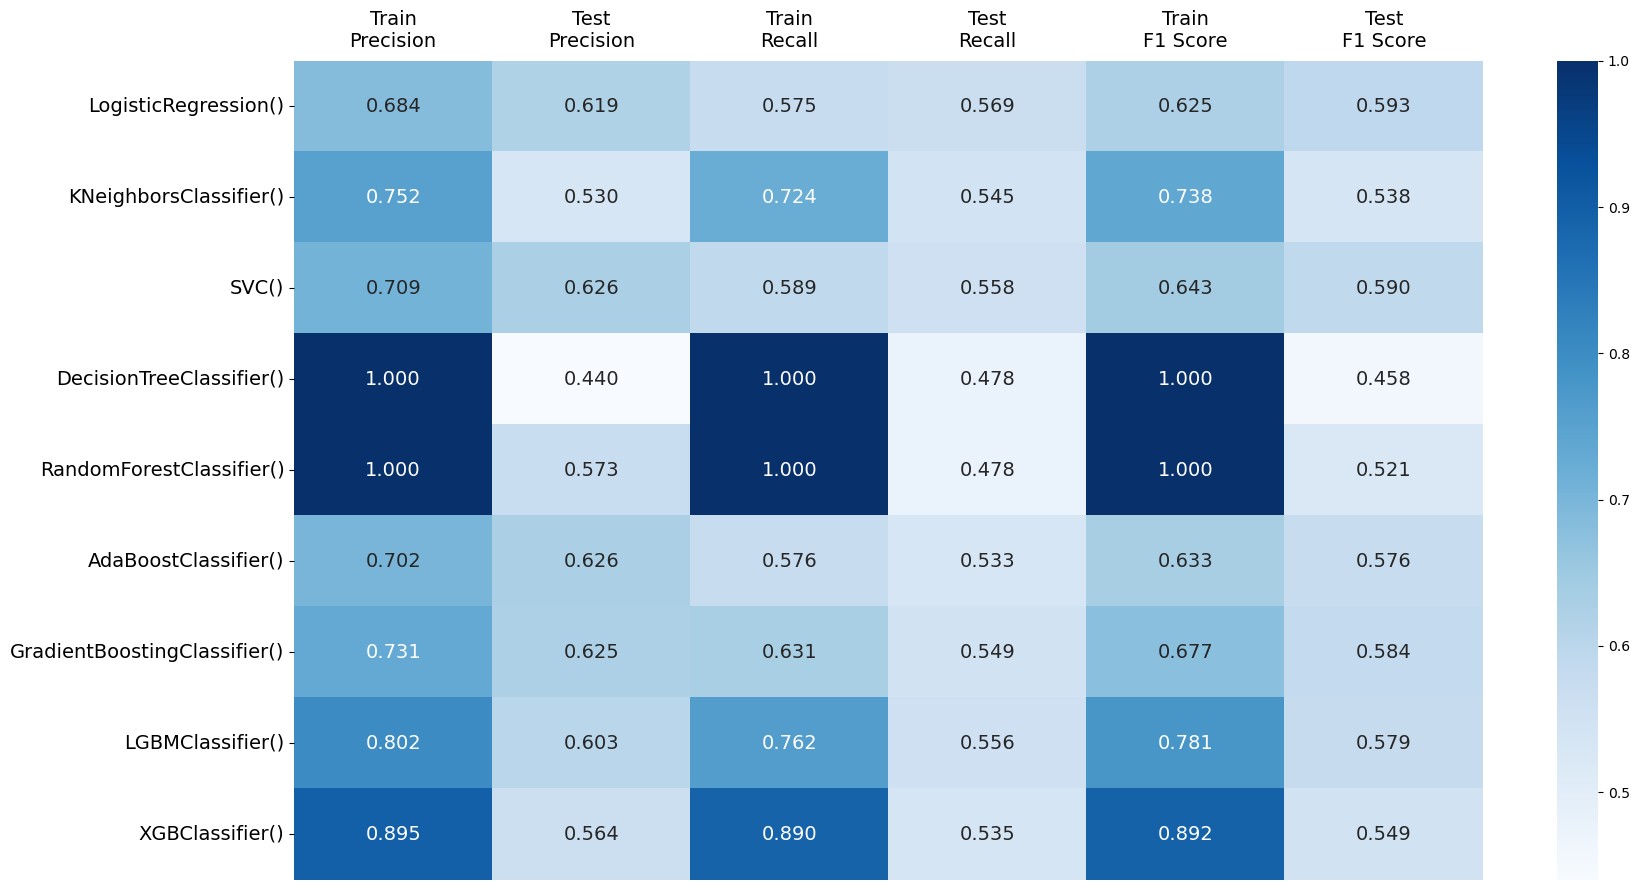

In [196]:
#Modeling
createmodel(X_smote,X_test_scaled, y_smote,y_test, models)

### Hyperparameter Tuning

In [197]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

We conduct hyperparameter tuning for best models selected based on F2-score.

#### Define Parameter Distribution

In [198]:
from jcopml.tuning import random_search_params as rsp, grid_search_params as gsp

In [199]:
# Define the hyperparameters and their values to search for Logistic Regression
lgr_param_grid = {
    'C': np.logspace(-3, 3, 7),  # Regularization strength (a range of values from 0.001 to 1000)
    'fit_intercept': [True, False],  # Whether to calculate the intercept for this model
    'class_weight': [None, 'balanced', {1:2, 0:1}, {1:3, 0:1}, {1:5, 0:1}],  # Weights to be used for classes (None for equal, 'balanced' for automatic balancing)
    'solver': ['sag', 'saga'],
    'penalty': ['l1', 'l2'],
}



# Define the base estimator (DecisionTreeClassifier) with personalized parameters
balanced_estimator = DecisionTreeClassifier(max_depth=1, class_weight='balanced')  # Adjust class_weight for imbalance

# Define the hyperparameters and their values to search for AdaBoost
ada_param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of weak learners (trees) to train
    'learning_rate': [0.001, 0.01, 0.1, 1],  # Step size for the weak learner's contribution
    'estimator': [None, balanced_estimator],  # The base estimator to use (None for DecisionTreeClassifier, or a custom estimator),
    'algorithm': ['SAMME', 'SAMME.R']
}


lgbm_param_grid = {
        'class_weight': [None, 'balanced'],
        'boosting_type': ['gbdt', 'rf'],  # Gradient Boosting Decision Tree
        'n_estimators': [100, 200, 300],  # Number of weak learners (trees) to train
        'learning_rate': [0.01, 0.1, 1],  # Step size for the weak learner's contribution
        'min_child_weight': [1e-3, 1],  # Minimum sum of instance weight needed in a child (leaf)
        'min_child_samples': [20],  # Minimum number of data needed in a child (leaf)
}

# gb_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 4, 5, 6],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'subsample': [0.8, 0.9, 1.0],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'scale_pos_weight': [1, 2, 5, 10]  # Parameter for handling imbalanced classes
# }

gb_param_grid = {
    # Boosting parameter
    'learning_rate': [0.05, 0.1, 0.2],
    # Tree parameter
    'n_estimators': [200],
     'min_samples_split': [0.5, 1, 2],
#     'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
}

In [200]:
# models_and_params = [(LogisticRegression(max_iter=1000, random_state=42, verbose=1), lgr_param_grid),
#                     (AdaBoostClassifier(random_state=42), ada_param_grid),
#                     (LGBMClassifier(random_state=42, silent=True), lgbm_param_grid)]

In [201]:
#models_and_params = [(GradientBoostingClassifier(random_state=42, verbose=0), gb_param_grid)]

In [202]:
 models_and_params = [(LogisticRegression(random_state=42, verbose=0), lgr_param_grid)]

In [203]:
import warnings
from sklearn.exceptions import ConvergenceWarning
# Filter out ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def createmodel_tune(x_train, x_test, y_train, y_test, models):
    # Perform GridSearchCV for each model
    performance = []
    for model, param_grid in models_and_params:
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
        grid_search.fit(x_train, y_train)
        
        y_pred = grid_search.predict(x_test)
        y_train_pred = grid_search.predict(x_train)
        
        performance.append([np.round(precision_score(y_train, y_train_pred, pos_label=1),3), np.round(precision_score(y_test, y_pred, pos_label=1),3),
                               np.round(recall_score(y_train, y_train_pred, pos_label=1),3), np.round(recall_score(y_test, y_pred, pos_label=1),3),
                                np.round(f1_score(y_train, y_train_pred, pos_label=1),3), np.round(f1_score(y_test, y_pred, pos_label=1),3)])

        print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    
    performance_df = pd.DataFrame(data=performance, columns='Train\nPrecision,Test\nPrecision,Train\nRecall,Test\nRecall,Train\nF1 Score,Test\nF1 Score'.split(","),
                                index=[model.__class__.__name__ + '()' for model, _ in models])
    plt.figure(figsize=(14, 10))
    sns.heatmap(performance_df, annot=True, cmap="Blues", annot_kws={"fontsize":14}, fmt=".3f")
    plt.tick_params(axis='both', which='major', labelsize=14, labelbottom = False, bottom=False, top = False, labeltop=True)
    plt.tight_layout()
    # Make Y-axis labels horizontal
    plt.yticks(rotation=0)
    plt.savefig('modelling_tune.png')
    plt.show()
    
    return performance_df

C:\Users\ASUS\anaconda3\envs\loan_prediction_env\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
350 fits failed out of a total of 1400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\envs\loan_prediction_env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ASUS\anaconda3\envs\loan_prediction_env\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\ASUS\anaconda3\envs\loan_prediction_env\lib\site-packages\sklearn\linear_mod

Best parameters for LogisticRegression: {'C': 0.01, 'class_weight': {1: 2, 0: 1}, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}


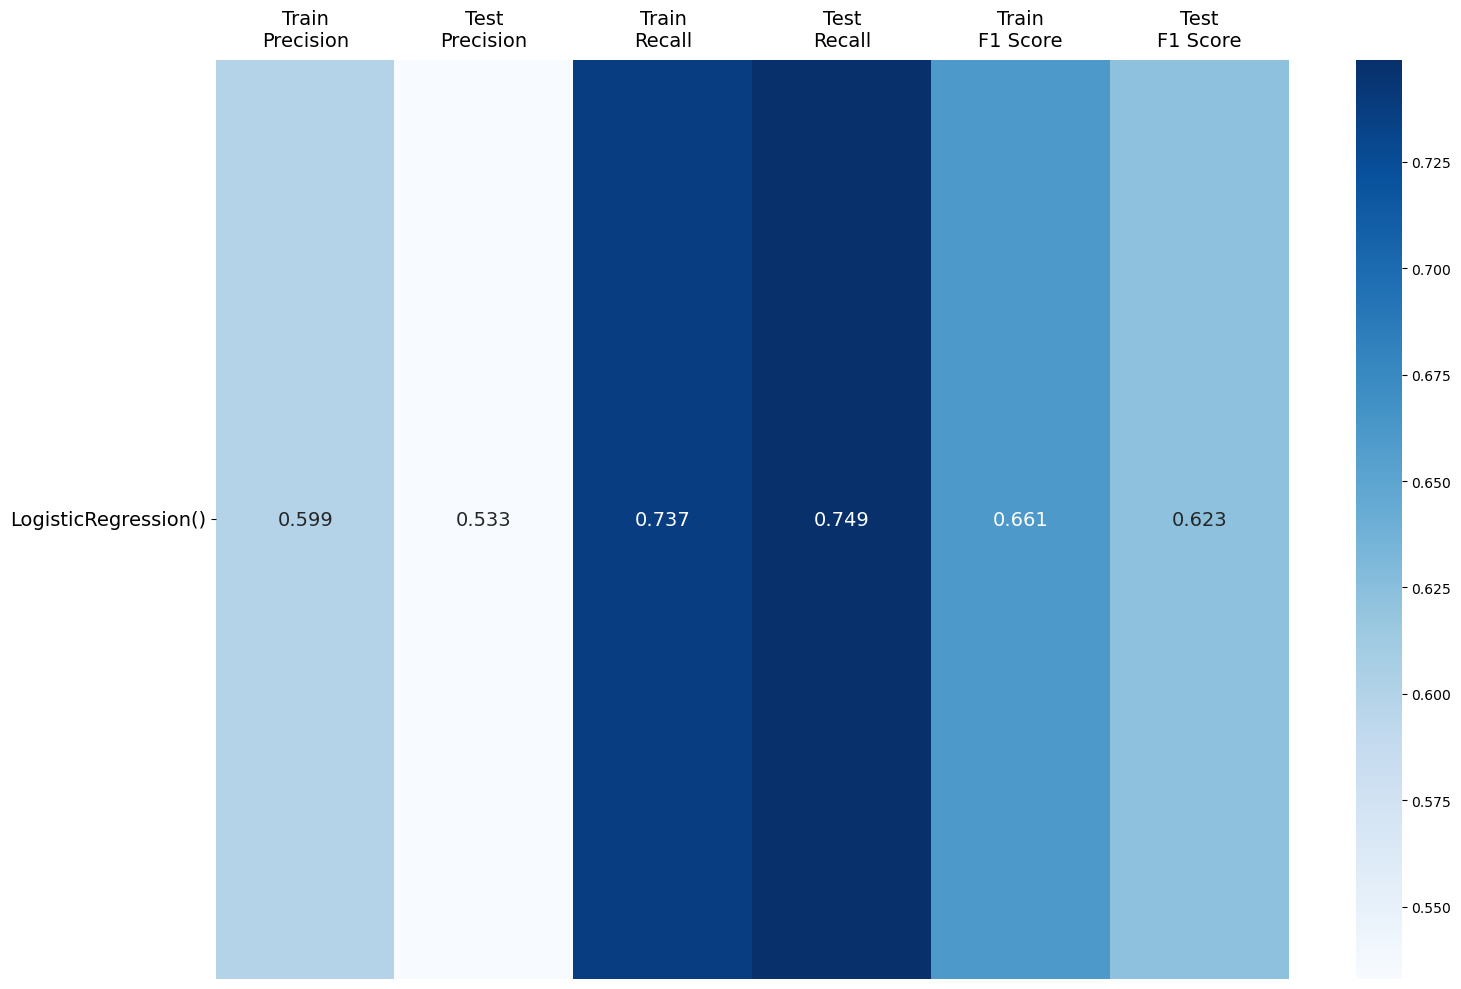

In [204]:
df_performance_tune = createmodel_tune(X_smote, X_test_scaled, y_smote ,y_test, models_and_params)

**Tuning History**
- Best parameters for LogisticRegression: {'C': 1.0, 'class_weight': 'balanced', 'fit_intercept': True}
- Best parameters for AdaBoostClassifier: {'algorithm': 'SAMME.R', 'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=1), 'learning_rate': 0.1, 'n_estimators': 300}
- Best parameters for LGBMClassifier: {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': 0.01, 'min_child_samples': 20, 'min_child_weight': 0.001, 'n_estimators': 300}


- Best parameters for LogisticRegression: {'C': 0.1, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag'}
- Best parameters for GradientBoostingClassifier: {'learning_rate': 0.05, 'max_features': 'sqrt', 'n_estimators': 200}

- Best parameters for LogisticRegression: {'C': 0.01, 'class_weight': {1: 2, 0: 1}, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}

#### Logistic Regression - Tuned

In [205]:
from sklearn.model_selection import cross_val_score

In [206]:
def summarize_training(train_X, test_X, train_y, test_y, train_pred_y, test_pred_y):
    print('TRAINING RESULT:')
    print('======================================================')
    print('F1 Score:', np.round(f1_score(train_y, train_pred_y, pos_label=1),3))
    print('F2 Score:', np.round(fbeta_score(train_y, train_pred_y, pos_label=1, beta=2),3))
    print('======================================================')
    print('Classification Report --------------------------------')
    print(classification_report(train_y, train_pred_y))
    print('======================================================')
    print('Confussion Matrix ------------------------------------')
    print(confusion_matrix(train_y, train_pred_y))

    print('\n======================================================')

    print('\nTESTING RESULT:')
    print('======================================================')
    print('F1 Score:', np.round(f1_score(test_y, test_pred_y, pos_label=1),3))
    print('F2 Score:', np.round(fbeta_score(test_y, test_pred_y, pos_label=1, beta=2),3))
    print('======================================================')
    print('Classification Report --------------------------------')
    print(classification_report(test_y, test_pred_y))
    print('======================================================')
    print('Confussion Matrix ------------------------------------')
    print(confusion_matrix(test_y, test_pred_y))

In [207]:
def plot_confusion_matrix(test_y, prediction_y):
    # Construct and display your confusion matrix.
    cf_matrix = confusion_matrix(test_y, prediction_y)

    group_names = ["True Negative", "False Positive", "False Negative",  "True Positive"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(7, 5))
    plt.title('Confusion Matrix')
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [208]:
#1 {'C': 100.0, 'fit_intercept': True}
#2 {'C': 0.01, 'class_weight': 'balanced', 'fit_intercept': True}
#3 {'C': 0.01, 'class_weight': {1: 2, 0: 1}, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
lgr = LogisticRegression(C=0.01, fit_intercept=True, class_weight={1: 2, 0: 1}, penalty='l1', solver='saga', random_state=42, max_iter=1000)
lgr.fit(X_smote, y_smote)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(lgr, X_smote, y_smote, cv=5, scoring='f1')

# Print the cross-validation scores
print(f"CV scores: {cv_scores}")
print(f"Train CV F1 Score: {cv_scores.mean()}")

y_train_pred = lgr.predict(X_smote)
y_test_pred = lgr.predict(X_test_scaled)

summarize_training(X_smote, X_test_scaled, y_smote, y_test, y_train_pred, y_test_pred)

CV scores: [0.68413793 0.6627566  0.65       0.65646732 0.64751958]
Train CV F1 Score: 0.6601762854473312
TRAINING RESULT:
F1 Score: 0.661
F2 Score: 0.705
Classification Report --------------------------------
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      3622
           1       0.60      0.74      0.66      1629

    accuracy                           0.77      5251
   macro avg       0.73      0.76      0.74      5251
weighted avg       0.78      0.77      0.77      5251

Confussion Matrix ------------------------------------
[[2817  805]
 [ 428 1201]]


TESTING RESULT:
F1 Score: 0.623
F2 Score: 0.693
Classification Report --------------------------------
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1552
           1       0.53      0.75      0.62       561

    accuracy                           0.76      2113
   macro avg       0.71      0.76      0.72      2113
weig

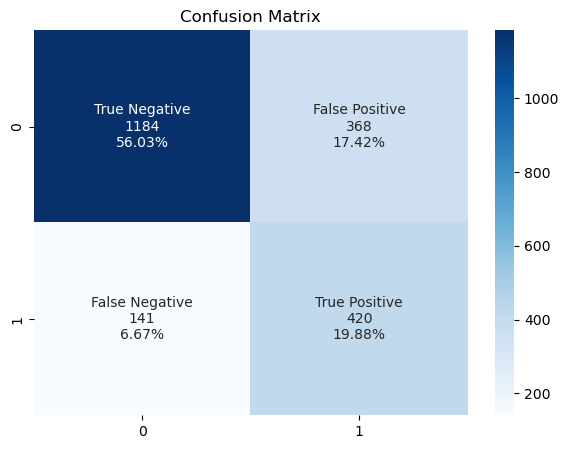

In [209]:
plot_confusion_matrix(y_test, y_test_pred)

##### Model Assumptions

- **Linearity Assumptions** states that there should be a linear relationship between each X variable and the logit of the probability that Y equals 1.
- **Independent Observation** relates to how the data was collected. Because the observations are assumed to be independent.
- **Multicollinearity** there is little to no multicolinearity between the independent variables. We have drop variables with more than 0.7 correlation coefficient.
- **No extreme outliers** We already check that there is no outliers in the dataset.

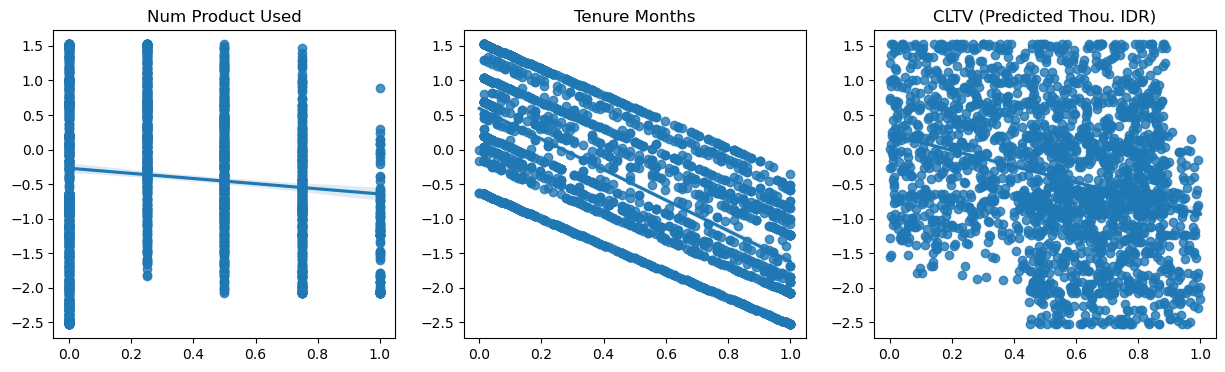

In [210]:
predicted_probs = lgr.predict_proba(X_test_scaled)[:, 1]
log_odds = np.log(predicted_probs / (1-predicted_probs))

# Create multiple plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()

numerical_idx = [X_test.columns.get_loc(feature) for feature in numerical_cols]

# only plot numerical columns
for i in range(len(numerical_cols)):
    ax=axes[i]
    sns.regplot(x=X_test_scaled[:,numerical_idx[i]], y=log_odds, ax=ax)
    ax.set_title(f'{X_test.columns.to_list()[numerical_idx[i]]}')

At this point, We are confidents that there are no assumptions that being violated.

##### Regression Analysis (Feature Importance)

In [211]:
def get_feature_importance(clf, feature_name, model):
    if model=='lgr':
        feature_importance = (
        pd.DataFrame(
        { 'variable': feature_name,
          'coefficient': clf.coef_[0],
         'absolute_coef': abs(clf.coef_[0]),
          'odds ratio': np.exp(clf.coef_[0])
        }
        ).round(decimals=2)\
         .sort_values('absolute_coef', ascending=False)
        )
    elif model =='ada':
        feature_importance = (
        pd.DataFrame(
        { 'variable': feature_name,
          'feature importance': np.mean([tree.feature_importances_ for tree in clf.estimators_], axis=0)
        }
        ).round(decimals=2)\
         .sort_values('feature importance', ascending=False)
        ).style.background_gradient()
        
    return feature_importance

- Koefisien Positive: Semakin tinggi nilainya semakin berkurang kemungkinan churnnya
- Koefisien Negative: Semakin tinggi nilainya semakin bertambah kemungkinan churnnya

In [212]:
df_feature_importance = get_feature_importance(lgr, X_test.columns, model='lgr')

In [213]:
df_feature_importance.columns

Index(['variable', 'coefficient', 'absolute_coef', 'odds ratio'], dtype='object')

In [214]:
df_feature_importance[['variable', 'coefficient', 'odds ratio']].style.background_gradient()

,variable,coefficient,odds ratio
1,Tenure Months,-1.910000,0.150000
3,Device Class,1.690000,5.390000
6,Payment Method_Pulsa,0.490000,1.630000
9,Games Product,-0.230000,0.800000
11,Call Center,-0.160000,0.850000
0,Num Product Used,0.000000,1.000000
2,CLTV (Predicted Thou. IDR),0.000000,1.000000
4,Payment Method_Debit,0.000000,1.000000
5,Payment Method_Digital Wallet,0.000000,1.000000
7,Music Product,0.000000,1.000000


**Increased Odds**
- If the customer has higher `Device Class` or for each one-unit increase in `Device Class`, their odds of getting churned is increase by 8 times.
- If the customer use `Payment Method_Pulsa`, their odds of getting churned is increase by 1.8 times than those who use `Credit Card as Payment Method`.
- If the customer  use `MyApp`, their odds of getting churned is increase by 1.37 times.
- If the customer use Telkomsel service to use `Video Product`, their odds of getting churned is increase by 1.36 times.


**Decrease Odds** <br>
- If the customer has higher `Tenure Months`, their odds of getting churned is decreased by 0.08 times.
- If the customer use Telkomsel service to use `Games Product`, their odds of getting churned is decreased by 0.63 times.
- If the customer use `Call Center`, their odds of getting churned is decreased by 0.64 times.
- If the customer has higher `Num Product Used`, their odds of getting churned is decreased by 0.74 times.

In [215]:
100*0.15

15.0

In [216]:
100*5.39

539.0

In [217]:
100*1.63

163.0

In [218]:
#Save Model
# path = './saved_model'
# with open(path+'/lgr_final_model.pickle', 'wb') as to_write:
#     pickle.dump(lgr, to_write)

#### Ada Boost - Tuned

In [219]:
#1 {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=1), 'learning_rate': 1, 'n_estimators': 300}
# 2 {'algorithm': 'SAMME.R', 'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=1), 
# 'learning_rate': 0.1, 'n_estimators': 300}

# Define the AdaBoostClassifier with personalized parameters
balanced_estimator = DecisionTreeClassifier(max_depth=1, class_weight='balanced')  # Adjust class_weight for imbalance

ada = AdaBoostClassifier(estimator=balanced_estimator, learning_rate=0.1, n_estimators=300, random_state=42)
ada.fit(X_smote, y_smote)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(ada, X_smote, y_smote, cv=5, scoring='f1')

# Print the cross-validation scores
print(f"CV scores: {cv_scores}")
print(f"Train CV F1 Score: {cv_scores.mean()}")

y_train_pred = ada.predict(X_smote)
y_test_pred = ada.predict(X_test_scaled)

summarize_training(X_smote, X_test_scaled, y_smote, y_test, y_train_pred, y_test_pred)

CV scores: [0.69588313 0.64796634 0.67115903 0.67108753 0.65321564]
Train CV F1 Score: 0.6678623346338748
TRAINING RESULT:
F1 Score: 0.674
F2 Score: 0.734
Classification Report --------------------------------
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      3622
           1       0.59      0.78      0.67      1629

    accuracy                           0.77      5251
   macro avg       0.74      0.77      0.75      5251
weighted avg       0.79      0.77      0.77      5251

Confussion Matrix ------------------------------------
[[2753  869]
 [ 359 1270]]


TESTING RESULT:
F1 Score: 0.628
F2 Score: 0.718
Classification Report --------------------------------
              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1552
           1       0.52      0.79      0.63       561

    accuracy                           0.75      2113
   macro avg       0.71      0.76      0.72      2113
weig

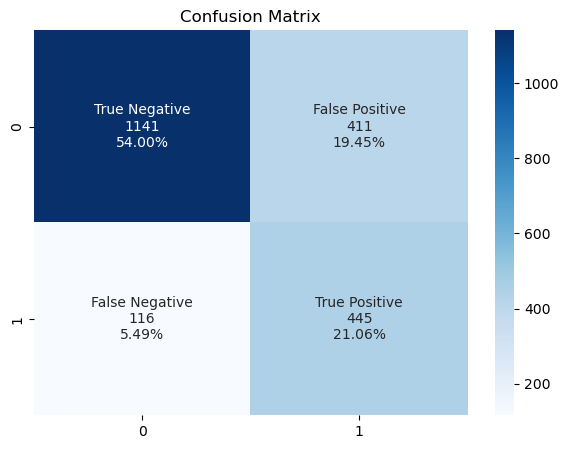

In [220]:
plot_confusion_matrix(y_test, y_test_pred)

##### Feature Importance ADA

In [221]:
get_feature_importance(ada, X_test.columns, model='ada')

,variable,feature importance
1,Tenure Months,0.270000
2,CLTV (Predicted Thou. IDR),0.230000
3,Device Class,0.140000
0,Num Product Used,0.110000
8,Video Product,0.070000
10,Use MyApp,0.060000
11,Call Center,0.050000
9,Games Product,0.030000
6,Payment Method_Pulsa,0.020000
5,Payment Method_Digital Wallet,0.010000


#### Modeling After Features Importance

##### Logistic Regression

In [222]:
importance_features = ['Device Class', 'Purchase Per Tenure Month', 'Payment Method_Pulsa', 'Use MyApp', 'Video Product', 'Internet Access']
numerical_idx = [X_test.columns.get_loc(feature) for feature in importance_features]

KeyError: 'Purchase Per Tenure Month'

In [ ]:
lgr = LogisticRegression(C=0.01, fit_intercept=True, class_weight='balanced', random_state=42, max_iter=1000)
lgr.fit(X_smote[:, numerical_idx], y_smote)

y_train_pred = lgr.predict(X_smote[:, numerical_idx])
y_test_pred = lgr.predict(X_test_scaled[:, numerical_idx])

print('TRAINING RESULT:')
print('======================================================')
print('F1 Score:', np.round(f1_score(y_smote, y_train_pred, pos_label=1),3))
print('======================================================')
print('Classification Report --------------------------------')
print(classification_report(y_smote, y_train_pred))
print('======================================================')
print('Confussion Matrix ------------------------------------')
print(confusion_matrix(y_smote, y_train_pred))

print('\n======================================================')

print('\nTESTING RESULT:')
print('======================================================')
print('F1 Score:', np.round(f1_score(y_test, y_test_pred, pos_label=1),3))
print('======================================================')
print('Classification Report --------------------------------')
print(classification_report(y_test, y_test_pred))
print('======================================================')
print('Confussion Matrix ------------------------------------')
print(confusion_matrix(y_test, y_test_pred))

##### AdaBoost 

In [ ]:
importance_features = ['Monthly Purchase (Thou. IDR)', 'Purchase Per Tenure Month', 'CLTV (Predicted Thou. IDR)', 'Device Class']
numerical_idx = [X_test.columns.get_loc(feature) for feature in importance_features]

In [ ]:
# Define the AdaBoostClassifier with personalized parameters
balanced_estimator = DecisionTreeClassifier(max_depth=1, class_weight='balanced')  # Adjust class_weight for imbalance

ada = AdaBoostClassifier(estimator=balanced_estimator, learning_rate=0.1, n_estimators=300, random_state=42)
ada.fit(X_smote[:, numerical_idx], y_smote)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(ada, X_smote[:, numerical_idx], y_smote, cv=5, scoring='f1')

# Print the cross-validation scores
print(f"CV scores: {cv_scores}")
print(f"Train CV F1 Score: {cv_scores.mean()}")

y_train_pred = ada.predict(X_smote[:, numerical_idx])
y_test_pred = ada.predict(X_test_scaled[:, numerical_idx])

print('TRAINING RESULT:')
print('======================================================')
print('F1 Score:', np.round(f1_score(y_smote, y_train_pred, pos_label=1),3))
print('======================================================')
print('Classification Report --------------------------------')
print(classification_report(y_smote, y_train_pred))
print('======================================================')
print('Confussion Matrix ------------------------------------')
print(confusion_matrix(y_smote, y_train_pred))

print('\n======================================================')

print('\nTESTING RESULT:')
print('======================================================')
print('F1 Score:', np.round(f1_score(y_test, y_test_pred, pos_label=1),3))
print('======================================================')
print('Classification Report --------------------------------')
print(classification_report(y_test, y_test_pred))
print('======================================================')
print('Confussion Matrix ------------------------------------')
print(confusion_matrix(y_test, y_test_pred))

# Recommendations

## Logistic Regression Recommendations

In [ ]:
get_feature_importance(lgr, X_test.columns, model='lgr')

**Tenure Month (Coefficient: -2.5, Odds Ratio: 0.08)**
> For each additional month of tenure, the odds of churning decrease by a factor of 0.08. Longer tenure indicates a higher likelihood of customer retention. Focus on customer engagement strategies for newer customers to increase their tenure. Encourage customer loyalty and retention programs that reward long-term customers. Consider offering special discounts or benefits to customers who have been with the company for an extended period.

**Device Class (Coefficient: 2.09, Odds Ratio: 8.09)**
> Customers using "High End" devices are more likely to churn compared to those using "Mid End" or "Low End" devices. It's essential to understand why customers with high-end devices are more likely to churn. Consider conducting user experience surveys or feedback sessions specific to this segment. Identify pain points and work towards improving their experience. Consider offering incentives or discounts for customers using high-end devices. This could be in the form of exclusive content, faster customer support, or early access to new features.

**Payment Method_Pulsa (Coefficient: 0.59, Odds Ratio: 1.81)**
> Customers using the "Pulsa" payment method have a slightly increased likelihood of churning. Investigate whether there are any specific pain points or challenges associated with this payment method. Consider providing additional support or incentives to these customers. This could be in the form of discounts, cashback, or exclusive offers tied to digital wallets or credit/debit cards.

**Games Product (Coefficient: -0.46, Odds Ratio: 0.63)**
> Customers using the 'Games Product' are less likely to churn compared to those who do not use it. Highlight the benefits and features of the 'Games Product' to all customers, especially those who have not yet adopted it. Consider targeted promotions or trials to encourage adoption and reduce churn.

Overall Recommendations:

- Segmentation and Personalization: Consider segmenting customers based on these factors and tailor marketing messages and offers accordingly. Personalization can significantly improve customer satisfaction and retention.

- Feedback Mechanism: Implement a system for gathering feedback from customers. This can help identify pain points and areas for improvement.

- Continuous Engagement: Stay in touch with your customers through various channels. Provide regular updates, relevant content, and special offers to keep them engaged and satisfied.

- Customer Support: Ensure that customer support is readily available and responsive. Addressing issues promptly can prevent dissatisfaction and churn.

- AB Testing: Remember to validate these recommendations with further analysis use A/B testing to ensure their effectiveness. This comprehensive approach will contribute to a more robust customer retention strategy.

These recommendations are based on the coefficients and odds ratios obtained from logistic regression model. It's important to continuously monitor customer behavior and adjust our strategies as needed. Additionally, consider conducting surveys or seeking direct feedback from customers to gain deeper insights into their preferences and concerns.

### Odds simulation

In [ ]:
def calculate_probs_by_odds(p_init, odds_ratio):
    if p_init == 0:
        init_odds = 0
    else:
        init_odds = p_init / (1 - p_init)

    new_odds = init_odds * odds_ratio

    new_probs = new_odds / (1 + new_odds)
    
    return new_probs

In [ ]:
def calculate_probs_by_odds_iterate(iterations, p_init, odds_ratio):
    curr = 0
    next = 0
    i = 0
    
    if iterations ==1:
        print(calculate_probs_by_odds(p_init, odds_ratio))
        return
    
    # loop
    while(i < iterations-1):
        if i == 0:
            curr = calculate_probs_by_odds(p_init, odds_ratio)
            print(curr)
            next = calculate_probs_by_odds(curr, odds_ratio)
            print(next)
            i+=1
        else:
            next = calculate_probs_by_odds(next, odds_ratio)
            print(next)
            i+=1

In [ ]:
calculate_probs_by_odds(0.9, 0.15)

In [ ]:
calculate_probs_by_odds(0.9, 0.5)

In [ ]:
calculate_probs_by_odds_iterate(10, 0.61, 8.09)

In [ ]:
get_feature_importance(lgr, X_test.columns, model='lgr')

In [ ]:
calculate_probs_by_odds_iterate(5, 0.8, 0.64)

In [ ]:
calculate_probs_by_odds_iterate(2, 0.5, 8.09)

# References

- https://quantifyinghealth.com/interpret-logistic-regression-coefficients/
- https://dev.to/rokaandy/logarithmic-transformation-in-linear-regression-models-why-when-3a7c